In [1]:
import warnings
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_openml,load_iris,fetch_california_housing
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
RepeatedStratifiedKFold, 
cross_val_score, 
train_test_split, 
GridSearchCV,
cross_val_predict, 
learning_curve, 
validation_curve)
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error,zero_one_loss
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.evaluate import bias_variance_decomp
#sharper plots
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)

warnings.filterwarnings("ignore")

In [2]:
data_path = "D:/data/ml/" 

In [3]:
def plot_with_err(params: np.ndarray, fun_cv: np.ndarray, label: str) -> None:
    mus = np.mean(fun_cv, axis=-1)
    stds = np.std(fun_cv, axis=-1)
    plt.plot(params, mus, label=label)
    plt.fill_between(params, mus - stds, mus + stds, alpha=0.2)

Мы уже знаем, что среднеквадратичный риск на фиксированной выборке X можно расписать как 
$$E = Var(h) + Bias^2(h) + Noise(y)$$
Здесь $Bias^2(h) = E_x[(\overline{h}(X) - \overline{y}(X))^2]$ показывает, насколько средняя модель отклонится от матожидания таргета (идеальной модели). 
$Var(h) = E_{x,D}[(h(X, D) - \overline{h}(X))^2]$ - показывает разброс обученных моделей относительно среднего ответа. 
$Noise(y) = E_{x,y}[(\overline{y}(X) - Y)^2]$ - дисперсия самого таргета при фиксированном x. Это неустранимая ошибка, которой соответствует самый идеальный прогноз.

Смещение показывает, насколько хорошо можно с помощью данного семейства моделей приблизиться к оптимальной модели. Как правило, оно маленькое у сложных семейств и большое у относительно простых. Вопрос: Назовите такие семейства.

Дисперсия показывает, насколько будет изменяться предсказание в зависимости от выборки - то есть насколько ваше семейство склонно к переобучению. 


Построим для иллюстрации простой пример и проверим, соответствует ли утверждение, что при увеличении сложности модели уменьшится смещение. Также проверим, растет ли при увеличении сложности модели дисперсия. Для начала посмотрим на простую зависимость, довольно сильно зашумленную.

In [4]:
def f(x: np.ndarray) -> np.ndarray:
    return 2.5 * np.cos(1.5 * x)*x  + 1 * x
    
def generate_data(n_samples: int = 50, noise: float = 3, n_noise_samples: int = 1) -> tuple[np.ndarray, np.ndarray]:
  x = np.random.rand(n_samples) * 20 - 10
  x = np.sort(x)

  y = np.zeros((n_samples, n_noise_samples))
  for i in range(n_noise_samples):
      y[:, i] = f(x) + np.random.normal(0.0, noise, n_samples)

  return x.reshape((n_samples, 1)), y.squeeze()

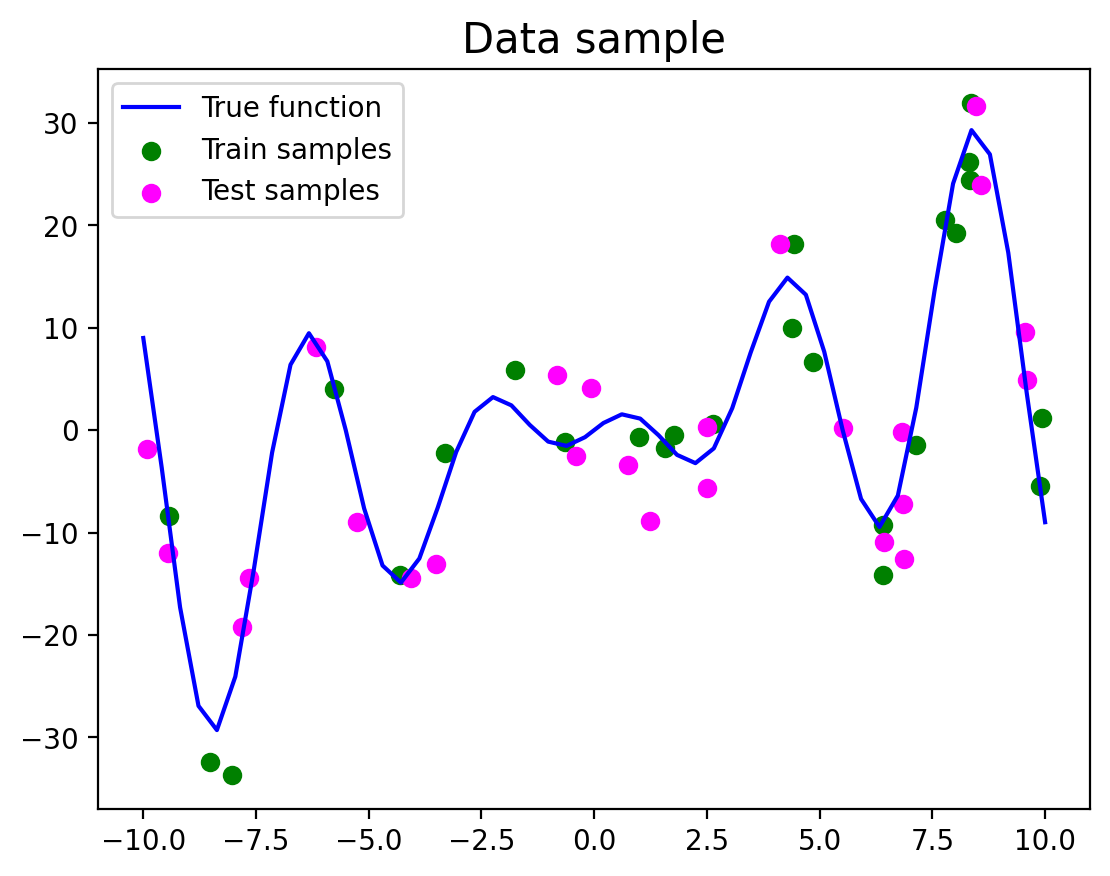

In [5]:

x_ticks = np.linspace(-10, 10)
X, y = generate_data(noise=4)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

plt.title('Data sample', fontsize=15)
plt.plot(x_ticks, f(x_ticks), color="blue", label="True function")
plt.scatter(x_train, y_train, color="green", label="Train samples")
plt.scatter(x_test, y_test, color="magenta", label="Test samples")
plt.legend()
plt.show()

Теперь мы можем сгенерировать датасеты и попробовать обучать модели на них:

In [6]:
def train_on_subset(model_class: type, parameters: dict, n_train_samples: int = 20, noise: float = 3) -> tuple:
  x_train, y_train = generate_data(n_samples=n_train_samples, noise=noise)
  model = model_class(**parameters)
  model.fit(x_train, y_train)
  return model, x_train, y_train

Для начала посмотрим, как вообще будет выглядеть предсказание в зависимости от глубины дерева. Задание: Постройте 

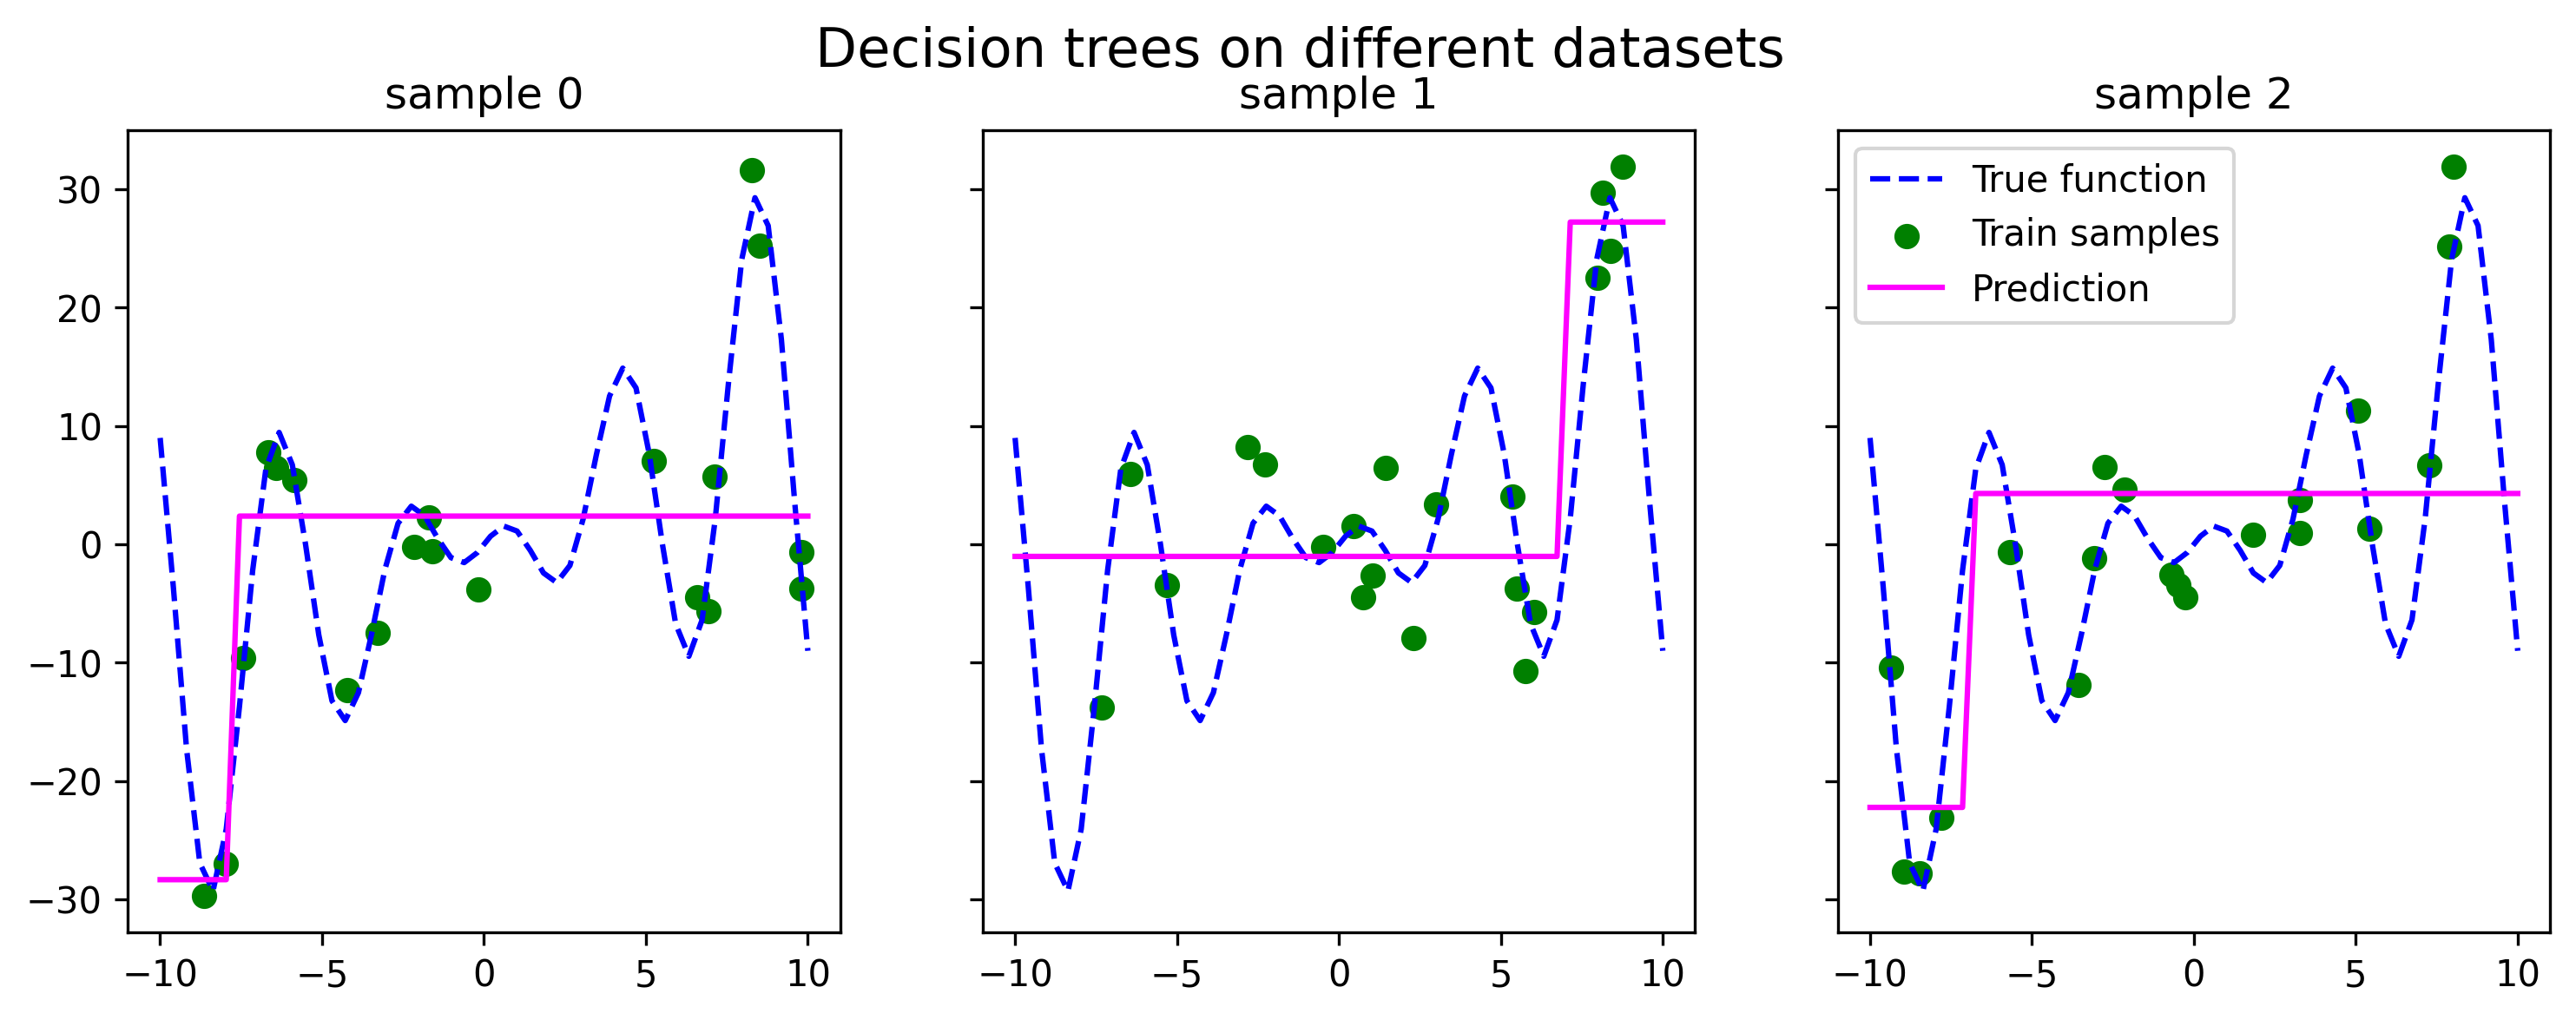

In [7]:
parameters = {"max_depth": 1}
np.random.seed(1243)

fig, ax = plt.subplots(1, 3, figsize=(12,4), dpi=150, sharey=True)
fig.suptitle("Decision trees on different datasets", fontsize=15)
for i in range(3):
    model, x_train, y_train = train_on_subset(model_class=DecisionTreeRegressor, parameters=parameters, noise=3)
    preds = model.predict(x_ticks[:, None])
    ax[i].plot(x_ticks, f(x_ticks), color="blue", label="True function", linestyle="--")
    ax[i].scatter(x_train, y_train, color="green", label="Train samples")
    ax[i].plot(x_ticks, preds, color="magenta", label="Prediction")
    ax[i].set_title(f"sample {i}")
plt.legend()

Теперь мы можем получить оценки ошибки и ее составляющих. Для этого насемплируем 1000 выборок, предварительно выделив общий тест сет, и вычислим test MSE для каждой из выборок.

In [8]:
def get_predictions(
    model_cards: list,
    n_repeats: int, noise: float, n_train_samples: int, 
    n_test_samples: int, n_noise_samples: int) -> list:
  
    x_test, y_test = generate_data(n_samples=n_test_samples, 
                                 n_noise_samples=n_noise_samples, noise=noise)
    predictions = {}
    results = []
    
    for i, (model_class, parameters) in enumerate(model_cards):
        np.random.seed(12341)
        predictions[i] = [] 
        for j in tqdm(range(n_repeats), desc=f"{model_class.__name__}, {parameters}"):
            model, _, _ = train_on_subset(
              model_class=model_class, parameters=parameters, 
              n_train_samples=n_train_samples,
              noise=noise
            )
            preds = model.predict(x_test)
            predictions[i].append(preds)
            
        results.append({
          "name": model_class.__name__,
          "parameters": parameters,
          "predictions": np.stack(predictions[i]),
          "x_test": x_test,
          "y_test": y_test
        })
    return results

In [9]:
models = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    models,
    n_repeats=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 1}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 2}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 4}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 6}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 7}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 8}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 9}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 11}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 12}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 13}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 14}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 15}:   0%|          | 0/1000 [00:00<?, ?it/s]

**Задание**: Посчитайте размеры массивов предсказаний, x_test, y_test.

In [10]:
print(f"predictions shape: n_repeats x n_test_samples = {results[0]['predictions'].shape}")
print(f"x_test shape: n_test_samples x 1 = {results[0]['x_test'].shape}")
print(f"y_test shape: n_test_samples x n_noise_samples = {results[0]['y_test'].shape}")

predictions shape: n_repeats x n_test_samples = (1000, 500)
x_test shape: n_test_samples x 1 = (500, 1)
y_test shape: n_test_samples x n_noise_samples = (500, 300)


In [11]:
def get_bias_variance(results) -> pd.DataFrame:
  records = []
  for res in results:
    x_test, y_test = res["x_test"], res["y_test"]
    predictions = res["predictions"]
    bias = f(x_test).squeeze() - np.mean(predictions, axis=0)
    variance = np.var(predictions, axis=0)
    noise = np.var(y_test, axis=1)
    error = (predictions[..., None] - y_test[None]) ** 2

    records.append({
        "name": res["name"],
        "parameters": res["parameters"],
        "bias_sq": np.mean(bias ** 2),
        "variance": np.mean(variance),
        "noise": np.mean(noise),
        "mse": np.mean(error),
        "error_decomposed": np.mean(bias ** 2 + variance + noise)
    })
    
  return pd.DataFrame.from_records(records)

In [12]:
bias_variance_trees = get_bias_variance(results)
bias_variance_trees.head()

,name,parameters,bias_sq,variance,noise,mse,error_decomposed
0,DecisionTreeRegressor,{'max_depth': 1},84.501749,21.690904,8.907787,115.362773,115.100440
1,DecisionTreeRegressor,{'max_depth': 2},54.360331,8.628505,8.907787,72.106449,71.896622
2,DecisionTreeRegressor,{'max_depth': 3},33.658415,8.991385,8.907787,51.668307,51.557587
3,DecisionTreeRegressor,{'max_depth': 4},11.363136,11.373371,8.907787,31.674853,31.644294
4,DecisionTreeRegressor,{'max_depth': 5},3.391013,6.895233,8.907787,19.199623,19.194033


Теперь мы можем построить график разложения!

In [13]:
def plot_bias_variance(
    bias_variance_results: pd.DataFrame, 
    parameter_name: str,  
    parameter_values: list[float]
) -> None:
    plt.figure(figsize=(8, 5), dpi=150)
    plt.xticks(parameter_values)
    plt.plot(parameter_values, bias_variance_results.bias_sq, label="bias²", color="blue")
    plt.plot(parameter_values, bias_variance_results.variance, label="variance", color="orange")
    plt.plot(parameter_values, bias_variance_results.noise, label="noise", color="green")
    plt.plot(parameter_values, bias_variance_results.mse, label="MSE", color="magenta")
    plt.xlabel(parameter_name)
    plt.ylabel("Error")
    plt.title("Bias-Variance Decomposition")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10, loc="upper right")
    plt.show()

In [14]:
def plot_all_predictions(
    results: list,
    x_ticks: np.ndarray,
    true_func: callable,
    model_idx: int = 0,
    alpha: float = 0.01,
    n_samples_to_show: int = None
) -> None:
    res = results[model_idx]
    predictions = res["predictions"]
    x_test = res["x_test"].squeeze()
    
    if n_samples_to_show is None:
        n_samples_to_show = predictions.shape[0]
    else:
        n_samples_to_show = min(n_samples_to_show, predictions.shape[0])
    
    plt.figure(figsize=(12, 6), dpi=150)
    plt.plot(x_ticks, true_func(x_ticks), 'b-', linewidth=2.5, label='True function')
    
    for i in range(n_samples_to_show):
        pred_interp = np.interp(x_ticks, x_test, predictions[i])
        plt.plot(x_ticks, pred_interp, 'r-', alpha=alpha, linewidth=0.5)
    
    mean_pred = np.mean(predictions, axis=0)
    mean_pred_interp = np.interp(x_ticks, x_test, mean_pred)
    plt.plot(x_ticks, mean_pred_interp, 'g-', linewidth=2.5, label='Mean prediction')
    
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(f"All predictions for {res['name']} with {res['parameters']} (showing {n_samples_to_show} models)", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()


Визуализируем все предсказания моделей с прозрачностью, чтобы увидеть разброс предсказаний:


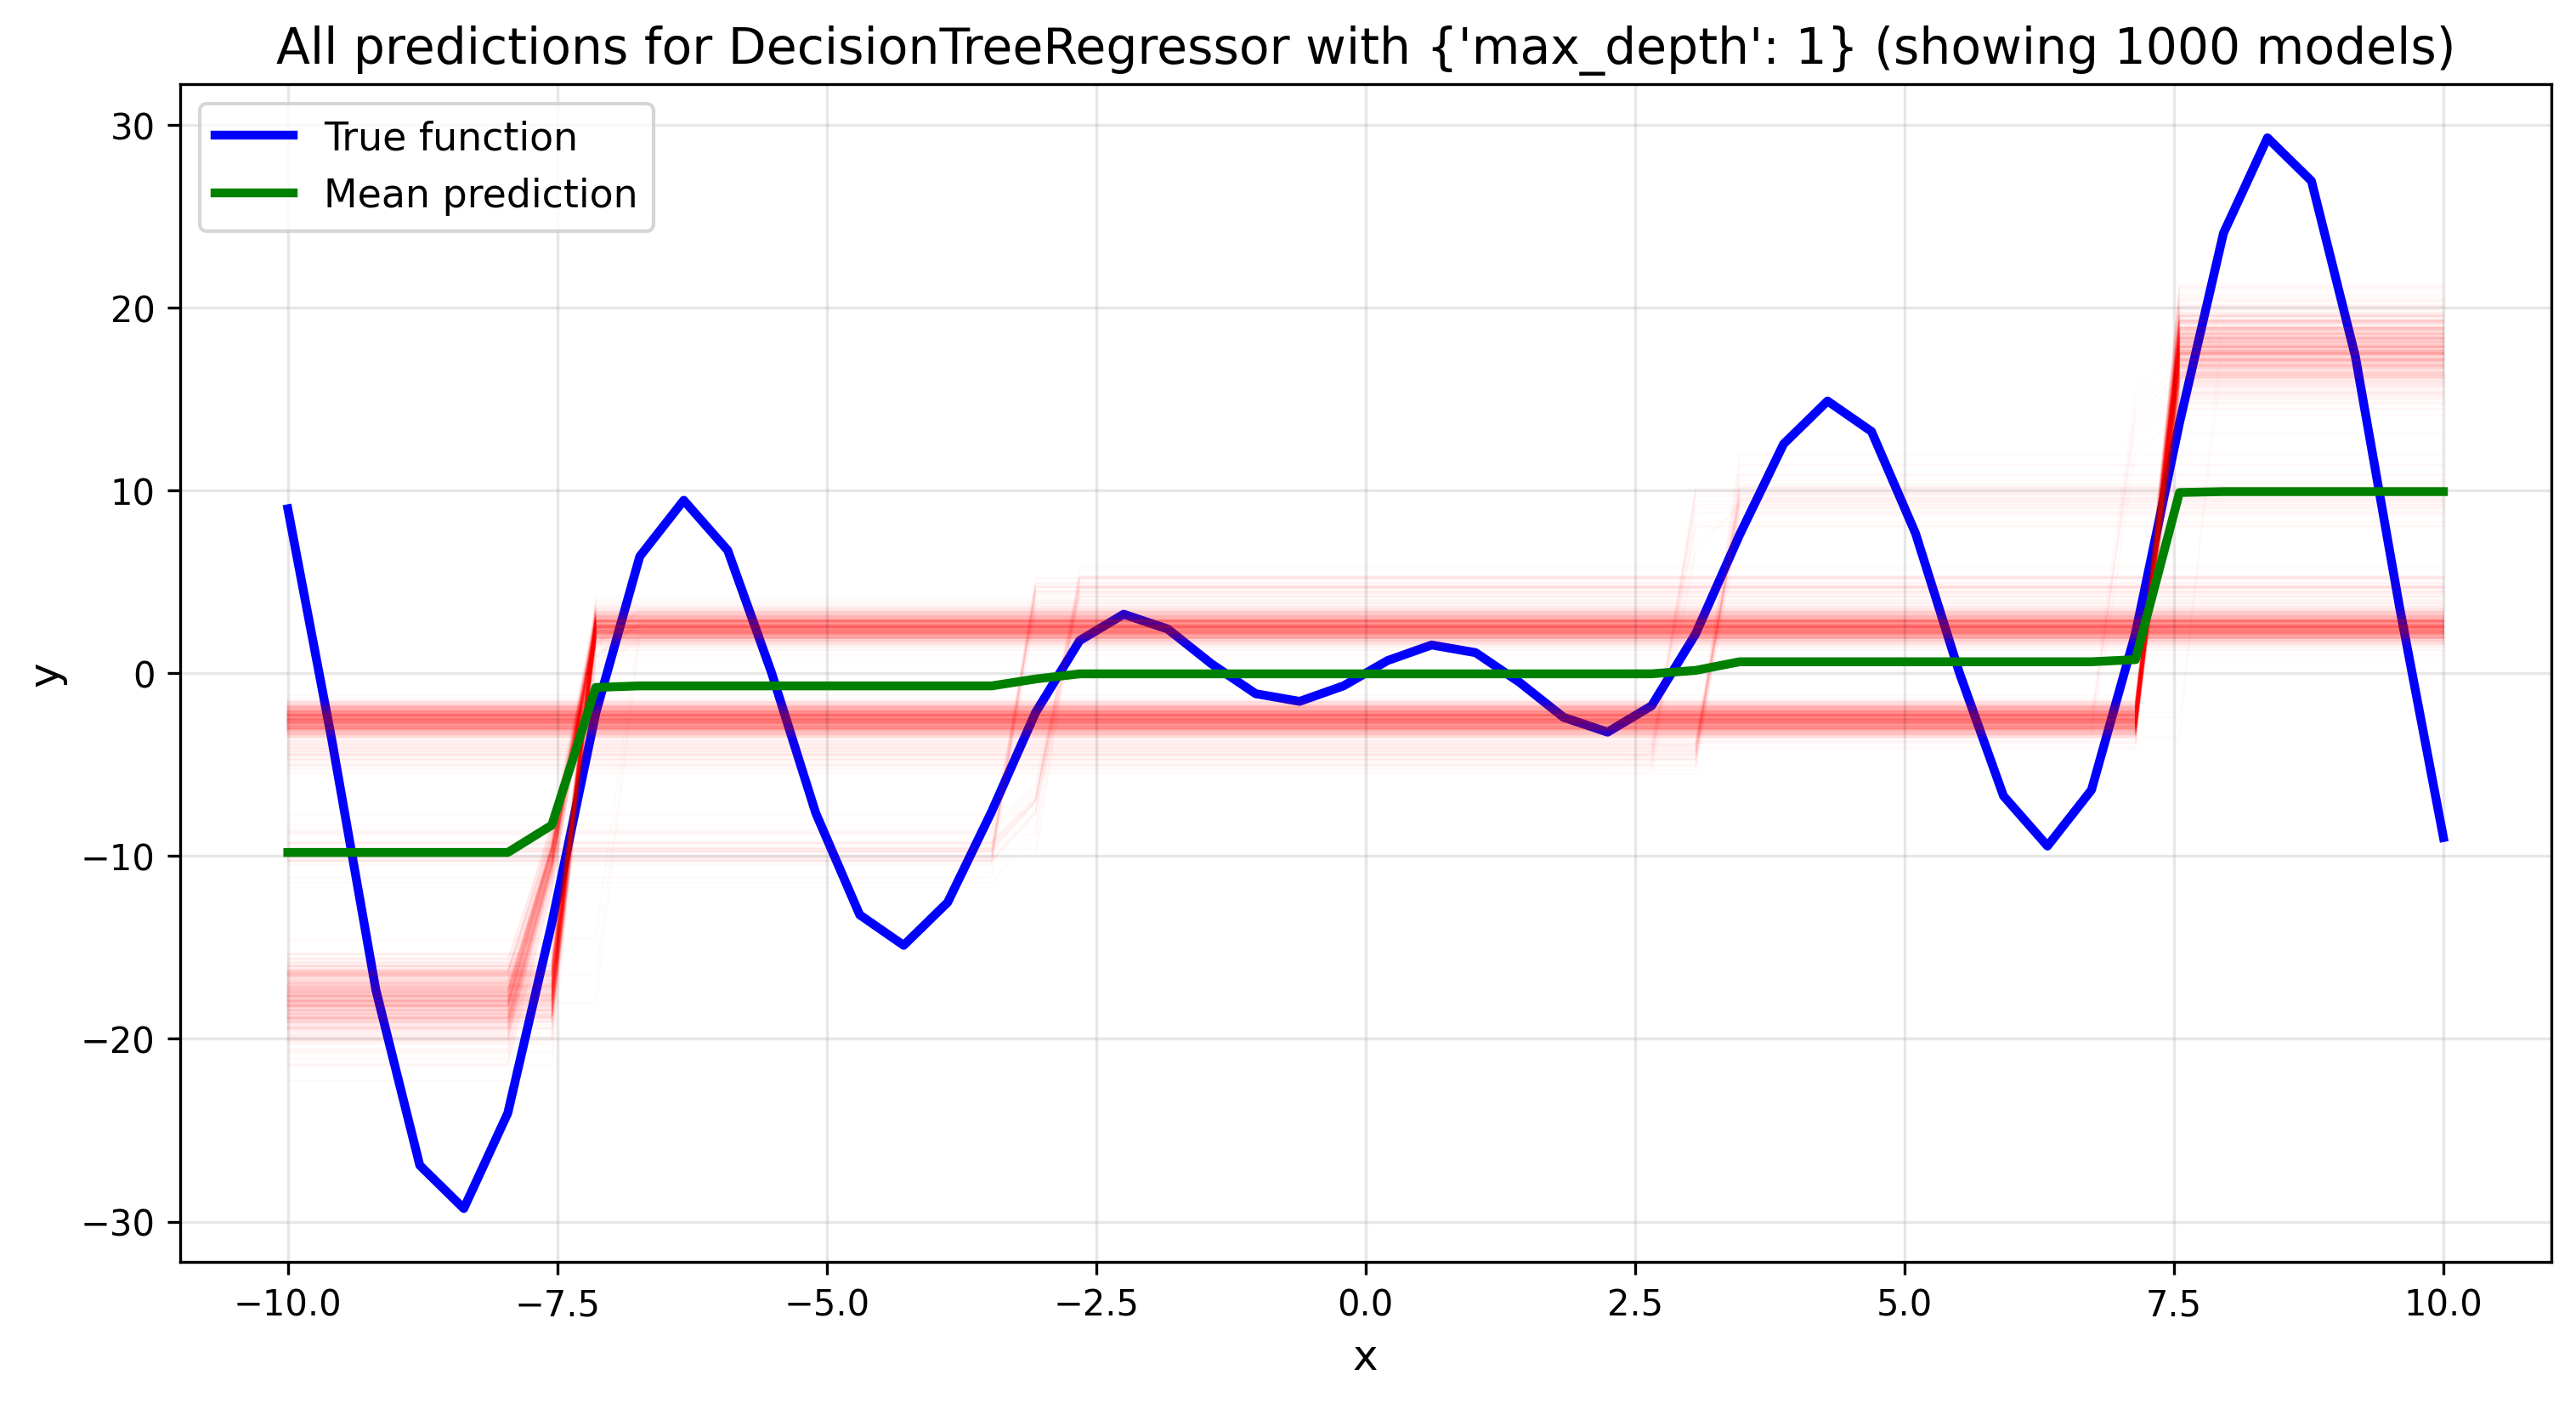

In [15]:
plot_all_predictions(results, x_ticks, f, model_idx=0, alpha=0.02)



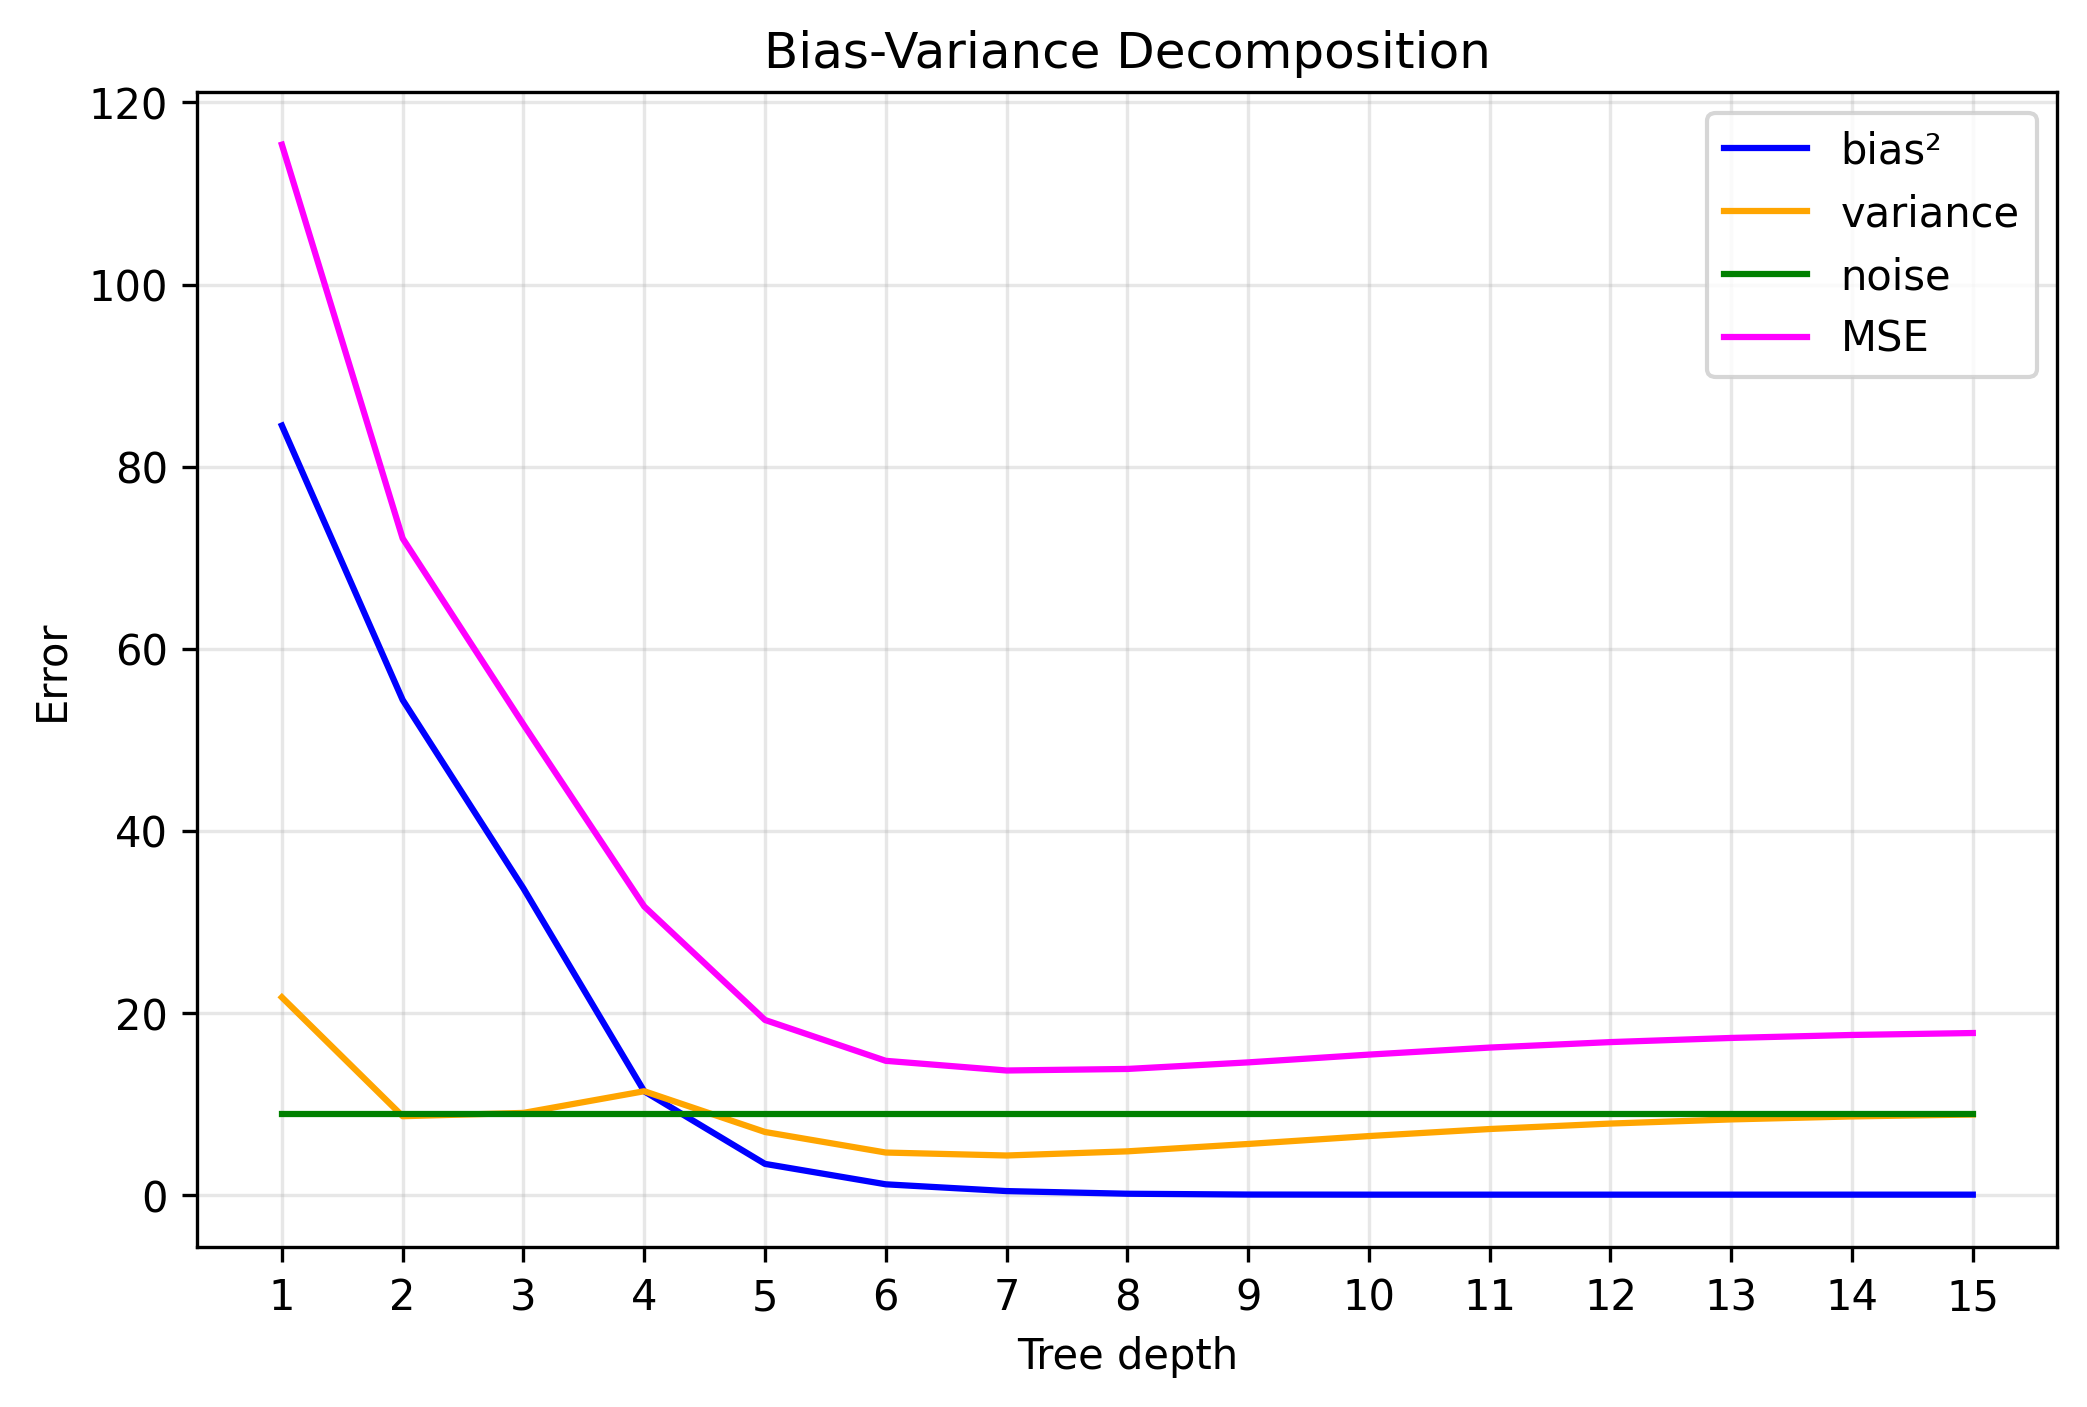

In [16]:
depth = bias_variance_trees.apply(lambda r: r.parameters["max_depth"], axis=1)

plot_bias_variance(bias_variance_trees, parameter_name="Tree depth",  parameter_values=depth)


Видно, что при увеличении глубины деревьев смещение падает практически до нуля, а разброс нарастает. Проверим, будет ли это сохраняться и дальше:

DecisionTreeRegressor, {'max_depth': 1}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 2}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 4}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 6}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 7}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 8}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 9}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 11}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 12}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 13}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 14}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 15}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 16}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 17}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 18}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 19}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 20}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 21}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 22}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 23}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 24}:   0%|          | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 25}:   0%|          | 0/1000 [00:00<?, ?it/s]

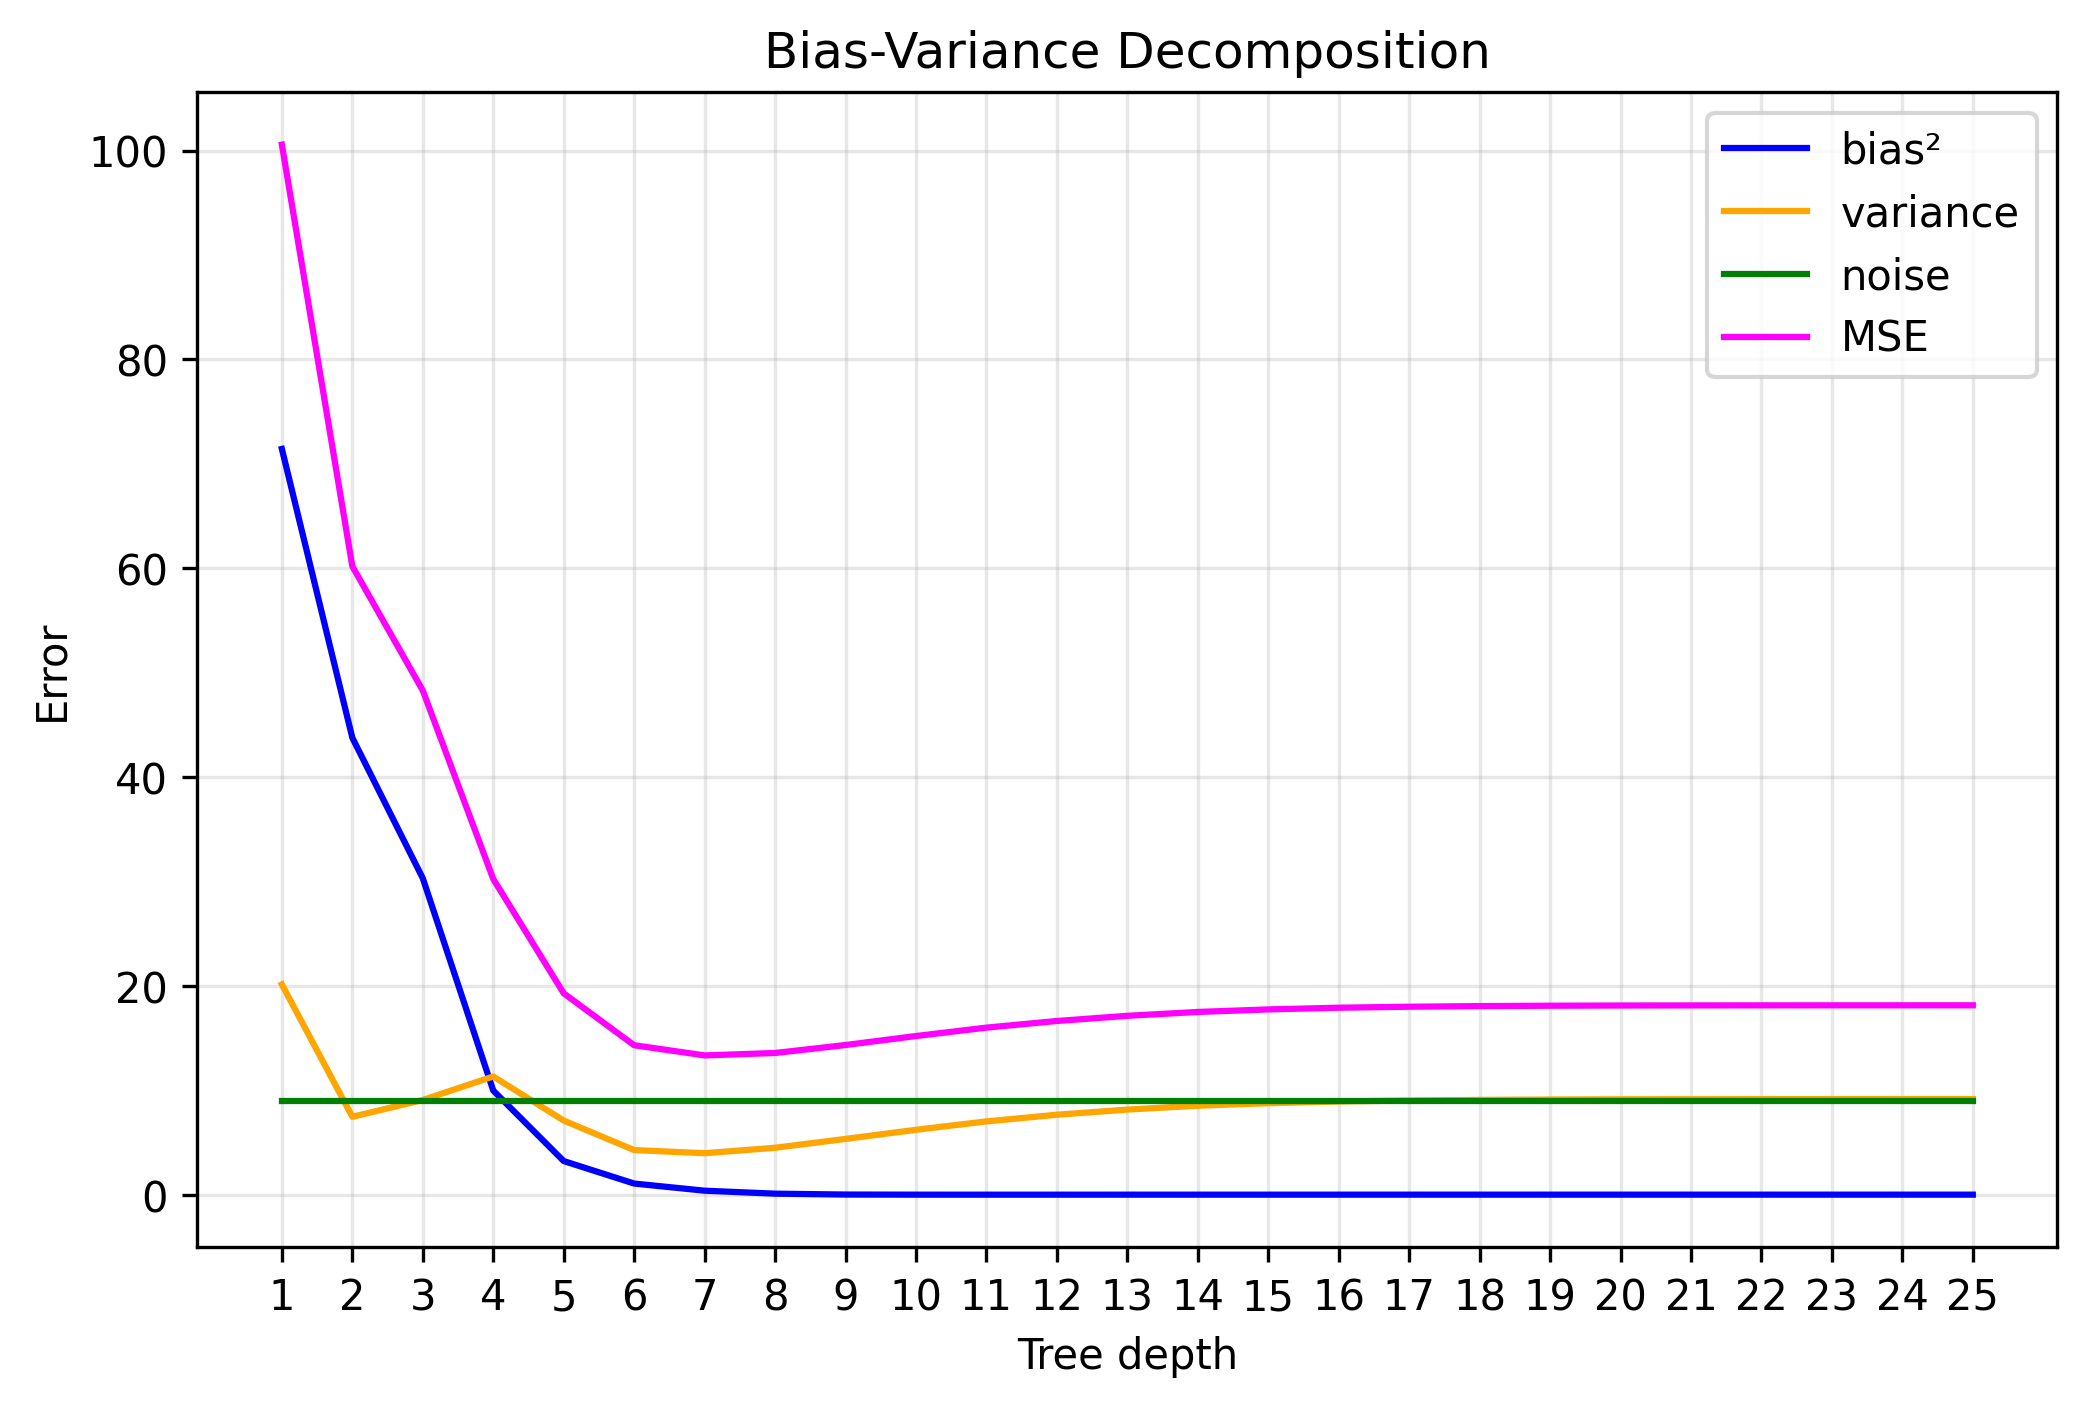

In [17]:

models = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 26)]

results = get_predictions(
    models,
    n_repeats=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)
bias_variance_many_trees = get_bias_variance(results)
plot_bias_variance(
    bias_variance_many_trees, 
    parameter_name="Tree depth",  
    parameter_values=bias_variance_many_trees.apply(lambda r: r.parameters["max_depth"], axis=1)
)
 

Вопрос: Почему с большой глубиной дерева значения ошибки и разложения перестают меняться? 

### Шум
Уровень шума в данных влияет на компоненту Noise в разложении ошибки. При увеличении шума:

- **Noise компонента** увеличивается - это неустранимая ошибка, которая показывает, насколько данные отклоняются от истинной функции
- **Bias и Variance** остаются относительно стабильными, так как они зависят от модели, а не от уровня шума
- **Общая ошибка (MSE)** увеличивается за счет роста Noise компоненты

Проведем эксперимент с разными уровнями шума:


In [18]:
noise_levels = [0.5, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0]
model_configs = [
    [DecisionTreeRegressor, {"max_depth": 3}],
    [DecisionTreeRegressor, {"max_depth": 5}],
    [DecisionTreeRegressor, {"max_depth": 10}],
]

results_by_noise = []
for noise in noise_levels:
    models = [[model_class, params] for model_class, params in model_configs]
    res = get_predictions(
        models,
        n_repeats=500,
        n_test_samples=500,
        n_train_samples=500,
        n_noise_samples=300,
        noise=noise
    )
    bv_df = get_bias_variance(res)
    bv_df['noise'] = noise
    results_by_noise.append(bv_df)

combined_noise_results = pd.concat(results_by_noise, ignore_index=True)


DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

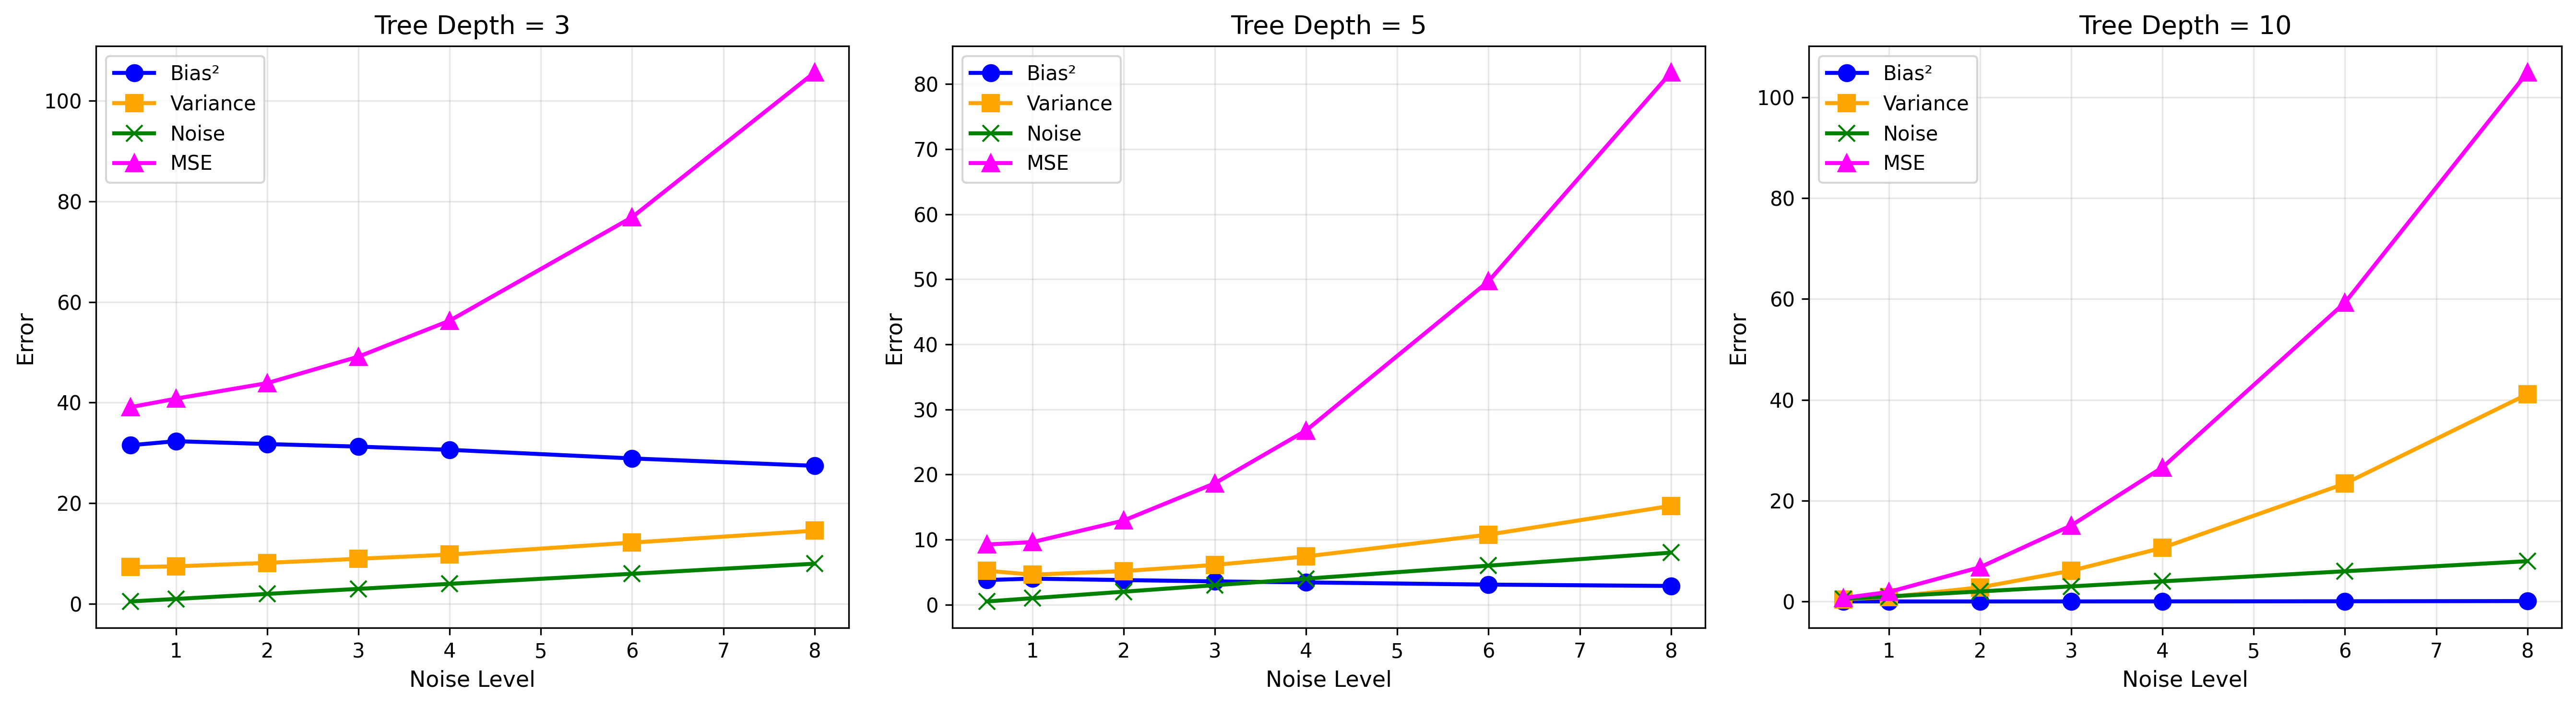

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)

for idx, depth in enumerate([3, 5, 10]):
    subset = combined_noise_results[combined_noise_results['parameters'].apply(lambda x: x.get('max_depth') == depth)]
    
    axes[idx].plot(subset['noise'], subset['bias_sq'], 'o-', label='Bias²', color='blue', linewidth=2, markersize=8)
    axes[idx].plot(subset['noise'], subset['variance'], 's-', label='Variance', color='orange', linewidth=2, markersize=8)
    axes[idx].plot(subset['noise'], subset['noise'], 'x-', label='Noise', color='green', linewidth=2, markersize=8)
    axes[idx].plot(subset['noise'], subset['mse'], '^-', label='MSE', color='magenta', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Noise Level', fontsize=11)
    axes[idx].set_ylabel('Error', fontsize=11)
    axes[idx].set_title(f'Tree Depth = {depth}', fontsize=13)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Задание**: Постройте зависимости для других сочетаний таргета и шума.

**Задание**: Постройте графики предсказаний всех 1000 деревьев на одном графике (и таргета тоже)

### Объем выборки

Размер обучающей выборки оказывает значительное влияние на bias-variance разложение:

- **При увеличении размера выборки**: Variance уменьшается, так как модель становится более стабильной и меньше зависит от конкретной выборки. Bias остается примерно постоянным, так как он зависит от способности семейства моделей приблизить истинную функцию, а не от размера выборки.

- **При малом размере выборки**: Variance высокая, так как модель сильно зависит от конкретных данных. Это может привести к переобучению даже на простых моделях.

Проведем эксперимент:


In [20]:
sample_sizes = [50, 100, 200, 500, 1000, 2000, 3000]
model_configs = [
    [DecisionTreeRegressor, {"max_depth": 3}],
    [DecisionTreeRegressor, {"max_depth": 5}],
    [DecisionTreeRegressor, {"max_depth": 10}],
]

results_by_size = []
for size in sample_sizes:
    models = [[model_class, params] for model_class, params in model_configs]
    res = get_predictions(
        models,
        n_repeats=500,
        n_test_samples=500,
        n_train_samples=size,
        n_noise_samples=300,
        noise=3
    )
    bv_df = get_bias_variance(res)
    bv_df['sample_size'] = size
    results_by_size.append(bv_df)

combined_results = pd.concat(results_by_size, ignore_index=True)


DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 3}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 5}:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTreeRegressor, {'max_depth': 10}:   0%|          | 0/500 [00:00<?, ?it/s]

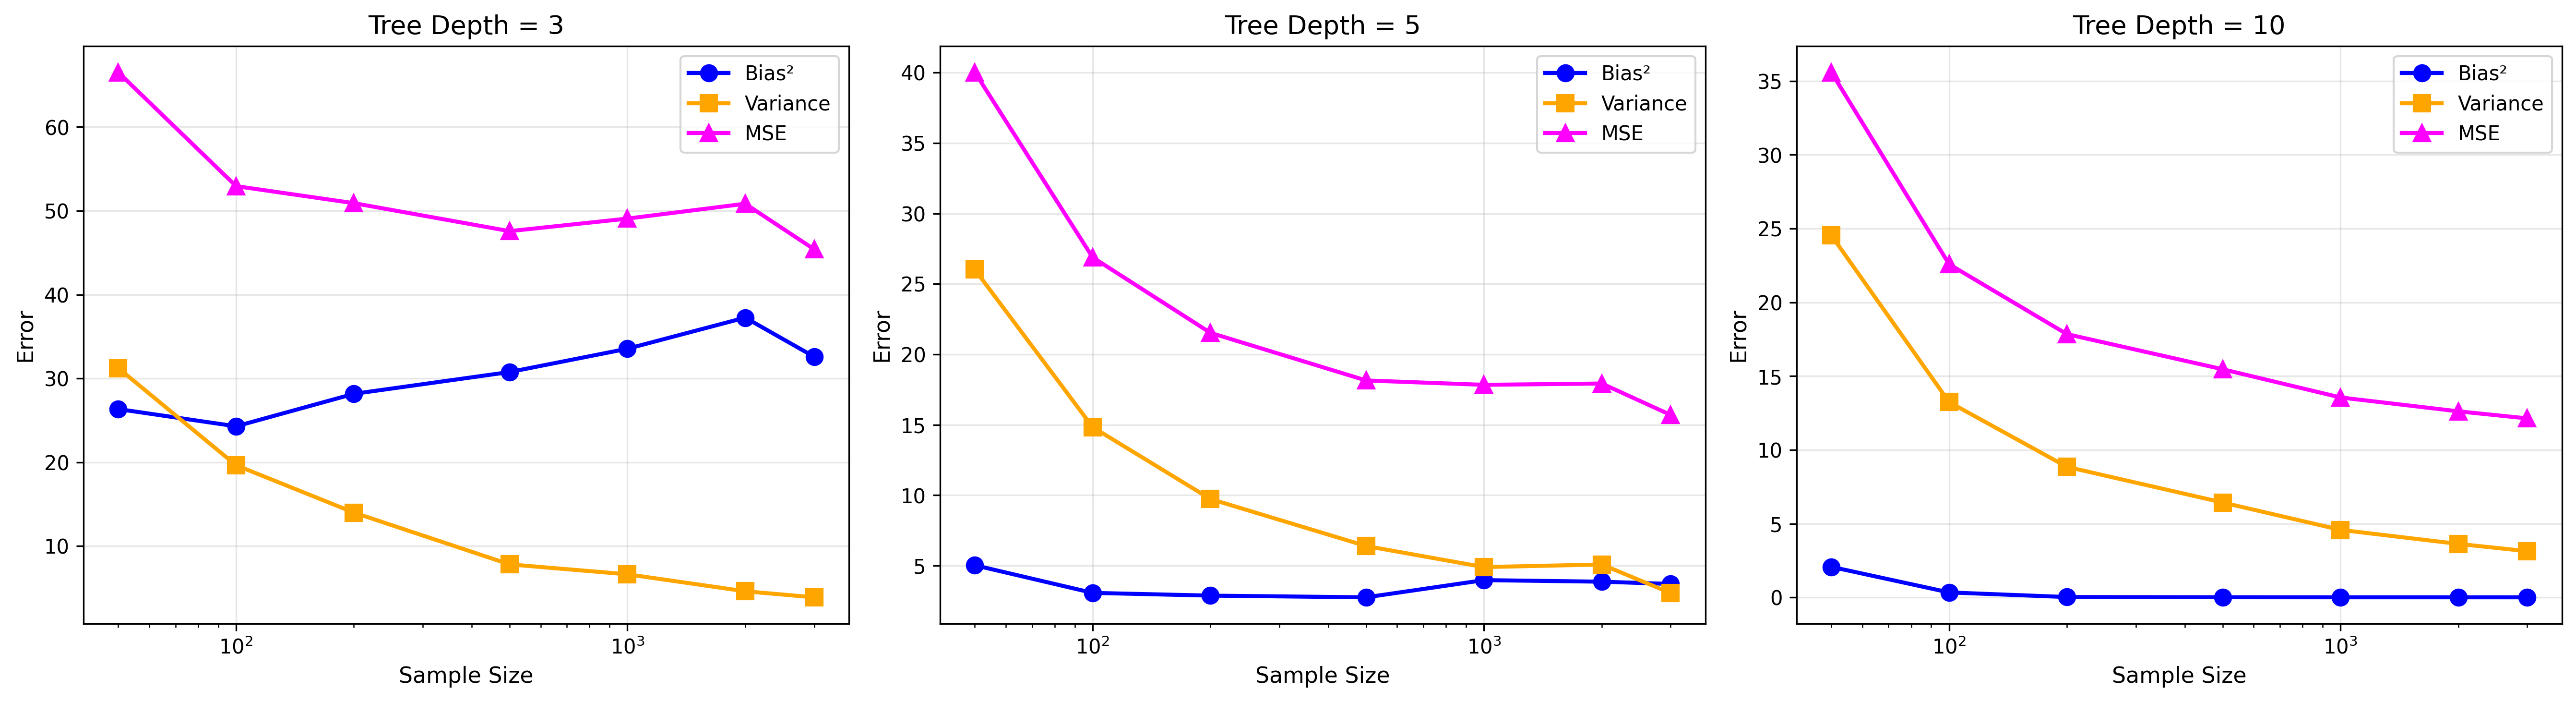

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)

for idx, depth in enumerate([3, 5, 10]):
    subset = combined_results[combined_results['parameters'].apply(lambda x: x.get('max_depth') == depth)]
    
    axes[idx].plot(subset['sample_size'], subset['bias_sq'], 'o-', label='Bias²', color='blue', linewidth=2, markersize=8)
    axes[idx].plot(subset['sample_size'], subset['variance'], 's-', label='Variance', color='orange', linewidth=2, markersize=8)
    axes[idx].plot(subset['sample_size'], subset['mse'], '^-', label='MSE', color='magenta', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Sample Size', fontsize=11)
    axes[idx].set_ylabel('Error', fontsize=11)
    axes[idx].set_title(f'Tree Depth = {depth}', fontsize=13)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xscale('log')

plt.tight_layout()
plt.show()


Перейдем к реальному примеру. Для таких данных, конечно, тоже можно посчитать, как раскладывается ошибка.

Рассмотрим разделение ошибки на примере данных о продаже зданий в Калифорнии. Разложение для некоторых функций, в том числе, для mse, поддерживается библиотекой mlextend. Сейчас попробуем ответить на два вопроса: действительно ли в реальной жизни ошибка подчиняется этому свойству и как изменение модели повлияет на разложение.

In [22]:
data = fetch_california_housing()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# Model definition
model = LinearRegression()
# Estimation of bias and variance using bias_variance_decomp
#Note here we are using loss as 'mse' and setting default bootstrap num_rounds to 200
mse, bias, var = bias_variance_decomp(
    model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=123
    )
y_pred=model.predict(X_test)
# summarize results
print('MSE from bias_variance lib [avg expected loss]: %.3f' % mse)
print('Avg Bias: %.3f' % bias)
print('Avg Variance: %.3f' % var)
print('Mean Square error by Sckit-learn lib: %.3f' % mean_squared_error(y_test,y_pred))

MSE from bias_variance lib [avg expected loss]: 0.527
Avg Bias: 0.525
Avg Variance: 0.002
Mean Square error by Sckit-learn lib: 0.527


Из приведенного выше очевидно, что общая ошибка = смещение + дисперсия, мы также могли видеть, что MSE, рассчитанная на основе библиотеки sckit, почти равна той, что мы получили их mlextend.

In [23]:
lasso_model = Lasso(alpha=0.05)
error_reg_las, bias_reg_las, var_reg_las = bias_variance_decomp(
    lasso_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=123
    )

y_pred=lasso_model.predict(X_test)
print('MSE from bias_variance lib [avg expected loss]: %.3f' % error_reg_las)
print('Avg Bias: %.3f' % bias_reg_las)
print('Avg Variance: %.3f' % var_reg_las)
print('Mean Square error by Sckit-learn lib: %.3f' % mean_squared_error(y_test,y_pred))

MSE from bias_variance lib [avg expected loss]: 0.555
Avg Bias: 0.554
Avg Variance: 0.001
Mean Square error by Sckit-learn lib: 0.554


Можно заметить, что после регуляризации смещение увеличилось, дисперсия немного уменьшилась, а общая средняя ошибка увеличилась (это нормально, если регуляризация слишком сильная).

Случайность ли наши результаты? Проверим их, сравнив разные модели на нашем наборе.

In [24]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

def compare_algorithms_bias_variance(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    algorithms: list,
    num_rounds: int = 200
) -> pd.DataFrame:
    results = []
    
    for name, model in algorithms:
        mse, bias, var = bias_variance_decomp(
            model, X_train, y_train, X_test, y_test,
            loss='mse', num_rounds=num_rounds, random_seed=123
        )
        results.append({
            'Algorithm': name,
            'MSE': mse,
            'Bias²': bias,
            'Variance': var,
            'Bias² + Variance': bias + var
        })
    
    return pd.DataFrame(results)

algorithms = [
    ('Linear Regression', LinearRegression()),
    ('Ridge (α=0.1)', Ridge(alpha=0.1)),
    ('Ridge (α=1.0)', Ridge(alpha=1.0)),
    ('Ridge (α=10.0)', Ridge(alpha=10.0)),
    ('Lasso (α=0.05)', Lasso(alpha=0.05)),
    ('Lasso (α=0.1)', Lasso(alpha=0.1)),
    ('Polynomial (deg=2)', Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])),
    ('Polynomial (deg=3)', Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression())
    ])),
]

comparison_df = compare_algorithms_bias_variance(
    X_train, y_train, X_test, y_test, algorithms
)
print(comparison_df.to_string(index=False))


         Algorithm      MSE    Bias²  Variance  Bias² + Variance
 Linear Regression 0.526879 0.524682  0.002197          0.526879
     Ridge (α=0.1) 0.526879 0.524683  0.002196          0.526879
     Ridge (α=1.0) 0.526878 0.524687  0.002192          0.526878
    Ridge (α=10.0) 0.526876 0.524729  0.002147          0.526876
    Lasso (α=0.05) 0.554821 0.553961  0.000860          0.554821
     Lasso (α=0.1) 0.602526 0.601975  0.000551          0.602526
Polynomial (deg=2) 0.480822 0.443452  0.037371          0.480822
Polynomial (deg=3) 3.987401 2.030065  1.957336          3.987401


**Задание:** Постройте график разложения для разных уровней регуляризации. При каком уровне регуляризации ошибка начинает увеличиваться из-за смещения?

### Bootstrap

Как же измеряются Bias и Variance? Конечно, мы не можем оценить bias и variance без доступа ко всем возможным выборкам, но можем приблизиться к решению задачи как можно ближе. Это можно сделать с помощью бутстрапирования выборки.

Бутстрап работает на удивление просто.
Предположим, что наша выборка D размера n на представляет генеральную совокупность. После этого мы можем сгененрировать эмпирическое распределение необходимой статистики, выбирая с замещением $N >> 100$ подвыборок объема n из этой совокупности (назовем псевдовыборками), и рассчитывая для них нужную статистику. 

![calib_1](../additional_materials/images/bootstrap.png)
Вообще, этот метод очень хорош для получения интервальных оценок, стандартных отклонений и прочего, даже если не задавать ограничения на распределения. 

Обратите внимание:
1) Чтобы оценка была несмещённой, необходимо генерировать выборки такого же размера, как и размер исходной выборки;
2) Количество итераций бутстрепа рекомендуется брать в диапазоне от 1000 до 10000. Этого, как правило, хватает для получения достаточно точных результатов.

Если бутстрап такой замечательный, то почему его не используют во всех задачах? Основной недостаток – его скорость работы. Для больших объемов данных вычисления могут требовать знчительных временных затрат. Во вторых, если в данных присутвтуют зависимости (выборки получаются не iid), то оценка не будет приближать исходное распределение. Так что разные особенности данных тоже надо учитывать. И последнее - если исходная выборка нерепрезентативна, то и результат будет не очень.

Вопрос: какие применения бутстрапа вы знаете?

Вопрос: как бутстрапом получить bias и variance? 

**Задание(*)**: Реализуйте функцию для вычисления смещения и дисперсии с помощью бутстрепа для MSE.

# Классификация

Существуют обобщения разложения. Последуем нотации из статьи Пьетро Домингоса, в которой, пожалуй, дан наиболее интуитивный варпиант общего разложения ошибки. В общем случае "главные" предсказания - это значения, которые отличаются наименее (по отношению к функции потерь $L$) от всех меток в Y: $y_{main} = argmin_{\hat{y}}(E(L(y, \hat y))$. В случае MSE это среднее, MAE - медиана. Для 0-1 лосса это мода. 

Тогда Bias и Variance можно определить как: Bias - это потери среднего предсказания по отношению к главному: $L(y, y_{main})$. Var - Средние потери предсказаний относительно среднего: $E(L(\hat{y}, y_{main})$. 

Тогда в общем случае разложение будет выглядеть как: 
$$E = с_1Var(h) + Bias(h) + с_2Noise(y),$$
где $с_1, c_2$ - константы, зависящие от лосса [[источник](https://homes.cs.washington.edu/~pedrod/papers/mlc00a.pdf)].

Рассмотрим 0–1 loss:

$$
\mathcal{L}_{01}(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^n \delta_{\hat{y_i} \neq y_i} \quad \text{with} \quad \delta_{\hat{y_i} = y_i} = 
\begin{cases} 
0, & \text{if } \hat{y_i} \neq y_{main} \\
1, & \text{otherwise}
\end{cases}
$$

Этот лосс не что иное как error rate. Он очень простой, но при этом не используется на практике как функция ошибки, но мы часто видим его как метрику. Вопрос: почему?

Смещение и дисперсия для потерь 0–1 следующие. $y_{main}$ в случае классификации представляет собой моду (наиболее часто встречающийся класс).

Смещение равно 1, если мода прогнозов не согласуется с истинной меткой , и 0 в противном случае:
$bias_i =  \begin{cases} 
1, & y ≠ y_{main} \\
0, & \text{otherwise}
\end{cases}$

Теперь к дисперсии. В случае 0-1 $Variance = P(\hat{y} \neq E[\hat{y}])$.

Рассмотрим случай, когда Bias=0. Тогда $Loss = Var$ (Опустим шум для упрощения).

Тогда, если подставить  $\mathcal{L}_{01}$ в формулы для обобщенного лосса, мы получим, что дисперсия определяется как вероятность того, что предсказанная метка не соответствует наиболее часто предсказанному:
$Var = P(\hat y \neq E[\hat y]) = P(\hat y \neq y_{main}])$

Теперь более сложный случай - когда Bias = 1. 

Посмотрев на определение Bias, мы получаем, что в такой ситуации $y \neq y_{main}$. Если y не равно моде предсказания, то получается, что и $\hat{y} = y$ (из переопределения Variance).

В итоге, выражение для лосса можно переписать как $L(y, \hat y) =  P(y \neq \hat y) = 1 - P(y = \hat y) = 1 - P(y \neq y_{main})$. А так как bias = 1, то мы получаем: $L(y, \hat y) =  Bias - Variance$

Получается, что увеличение Var может улучшить нашу модель! Неинтуитивно. Но, по утверждению авторов статьи, это имеет смысл, так как увеличение разброса двигает границу разбиения и некоторые пограничные семплы могут оказаться с нужной стороны.


Рассмотрим конкретный пример:


In [25]:
from sklearn.datasets import make_classification
from collections import Counter

X_simple, y_simple = make_classification(
    n_samples=200, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, random_state=42
)
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, y_simple, test_size=0.3, random_state=42, stratify=y_simple
)

models_to_compare = [
    ('DT depth=2', DecisionTreeClassifier(max_depth=2, random_state=42)),
    ('DT depth=5', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('DT depth=10', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('KNN k=1', KNeighborsClassifier(n_neighbors=1)),
    ('KNN k=5', KNeighborsClassifier(n_neighbors=5)),
]

nonadditivity_results = []
for name, model in models_to_compare:
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train_simple, y_train_simple, X_test_simple, y_test_simple,
        loss='0-1_loss', num_rounds=200, random_seed=42
    )
    nonadditivity_results.append({
        'Model': name,
        'Error': avg_expected_loss,
        'Bias': avg_bias,
        'Variance': avg_var,
        'Bias + Variance': avg_bias + avg_var,
        'Difference': avg_expected_loss - (avg_bias + avg_var)
    })

nonadditivity_df = pd.DataFrame(nonadditivity_results)
print(nonadditivity_df.to_string(index=False))


      Model    Error     Bias  Variance  Bias + Variance  Difference
 DT depth=2 0.168583 0.166667   0.06725         0.233917   -0.065333
 DT depth=5 0.198167 0.233333   0.09900         0.332333   -0.134167
DT depth=10 0.204083 0.200000   0.11075         0.310750   -0.106667
    KNN k=1 0.172750 0.166667   0.08325         0.249917   -0.077167
    KNN k=5 0.169750 0.166667   0.08925         0.255917   -0.086167


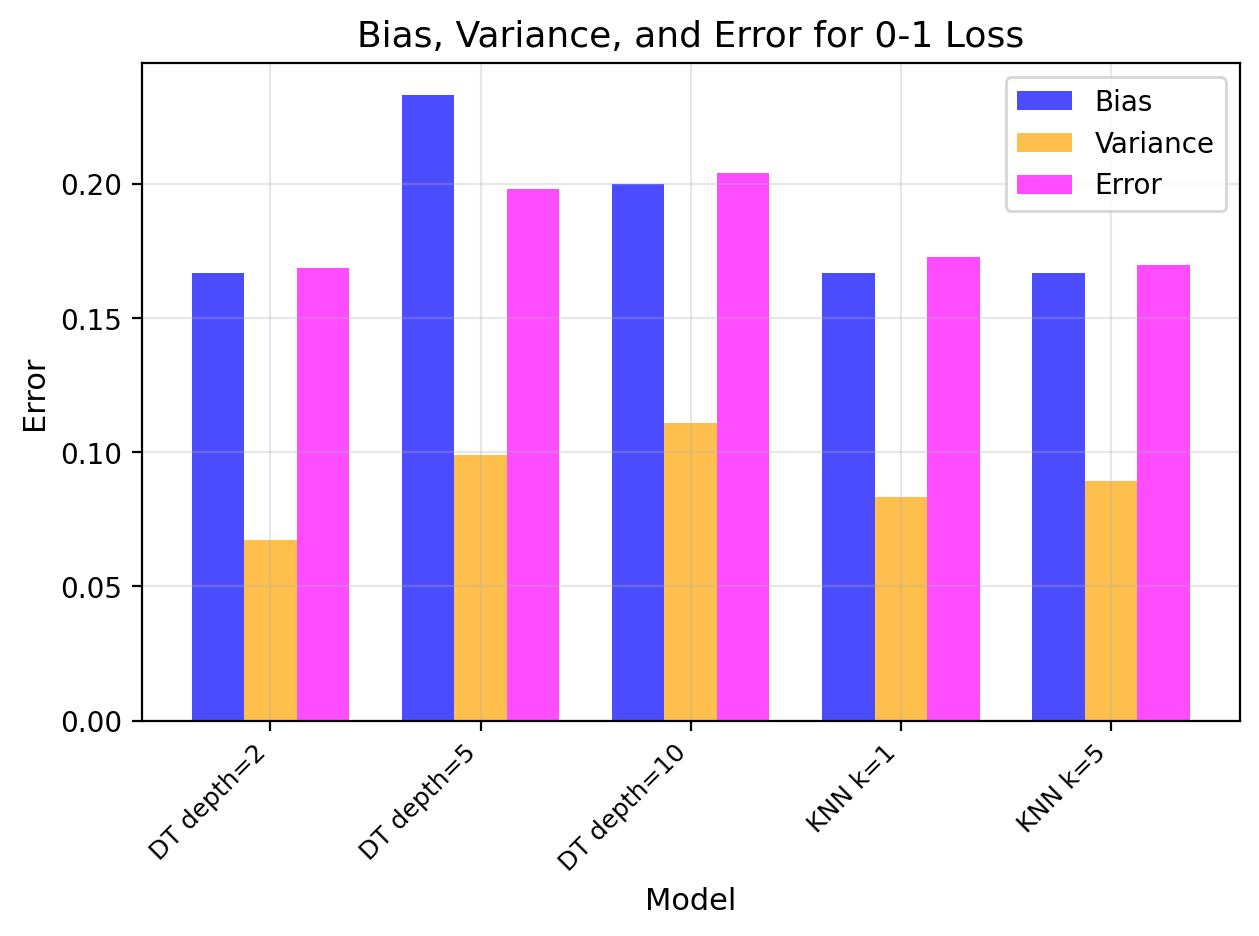

In [48]:
x_pos = np.arange(len(nonadditivity_df))
width = 0.25

plt.bar(x_pos - width, nonadditivity_df['Bias'], width, label='Bias', color='blue', alpha=0.7)
plt.bar(x_pos, nonadditivity_df['Variance'], width, label='Variance', color='orange', alpha=0.7)
plt.bar(x_pos + width, nonadditivity_df['Error'], width, label='Error', color='magenta', alpha=0.7)
plt.xlabel('Model', fontsize=11)
plt.ylabel('Error', fontsize=11)
plt.title('Bias, Variance, and Error for 0-1 Loss', fontsize=13)
plt.xticks(x_pos, nonadditivity_df['Model'], rotation=45, ha='right', fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


В качестве примера рассмотрим датасет Wisconsin Breast Cancer (WDBC). Этот датасет посвящен классификации рака груди. 

In [30]:
data = pd.read_csv(data_path + "wdbc/data.csv")
data = data.drop(['id', 'Unnamed: 32'], axis=1)
data['diagnosis'] = data['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)
y = data["diagnosis"].astype("int").values
X = data.drop("diagnosis", axis=1).values

## Деревья решений

In [32]:
degree = 2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)

In [33]:
pipeline = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "tree",
                DecisionTreeClassifier(random_state=123, max_depth=6),
            ),
        ]
    )
clf_dt = DecisionTreeClassifier(random_state=123)
#clf_dt.fit(X_train,y_train)
clf_dt.fit(X_train, y_train)
y_pred=clf_dt.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_dt, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))
print('Sklearn accuracy: %.3f' % clf_dt.score(X_test, y_test))

Average expected loss: 0.085
Average bias: 0.053
Average variance: 0.062
Sklearn 0-1 loss: 0.053
Sklearn accuracy: 0.942


Запруним наше дерево, уменьшив его сложность. 

In [34]:
### After Pruning ###
pipeline = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "tree",
                DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123),
            ),
        ]
    )
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        pipeline, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss--After pruning: %.3f' % avg_expected_loss)
print('Average bias--After pruning: %.3f' % avg_bias)
print('Average variance--After pruning: %.3f' % avg_var)
print('Sklearn 0-1 loss--After pruning: %.3f' % zero_one_loss(y_test,y_pred))

Average expected loss--After pruning: 0.057
Average bias--After pruning: 0.035
Average variance--After pruning: 0.047
Sklearn 0-1 loss--After pruning: 0.023


Теперь мы можем и посмотреть, как меняются составляющие с усложнениесм дерева.

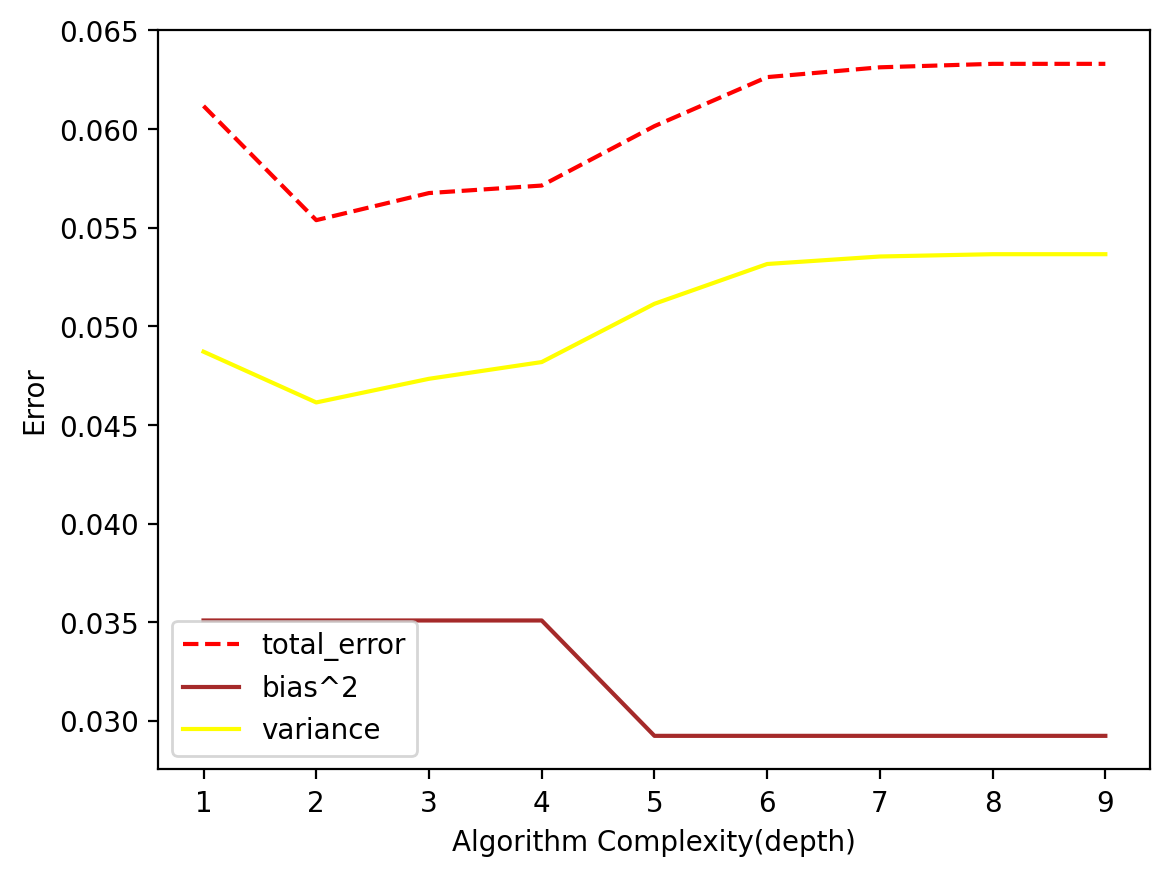

In [35]:
bias, var, error= [], [], []
max_d = 10
for d in range(1,max_d):
    clf = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "tree",
                DecisionTreeClassifier(max_depth=d, random_state=123),
            ),
        ]
    )
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=123)
    bias.append(avg_bias)
    var.append(avg_var)
    error.append(avg_expected_loss)
plt.plot(range(1,max_d), error, 'red', label = 'total_error',linestyle='dashed')
plt.plot(range(1,max_d), bias, 'brown', label = 'bias^2')
plt.plot(range(1,max_d), var, 'yellow', label = 'variance')
plt.xlabel('Algorithm Complexity(depth)')
plt.ylabel('Error')
plt.legend()

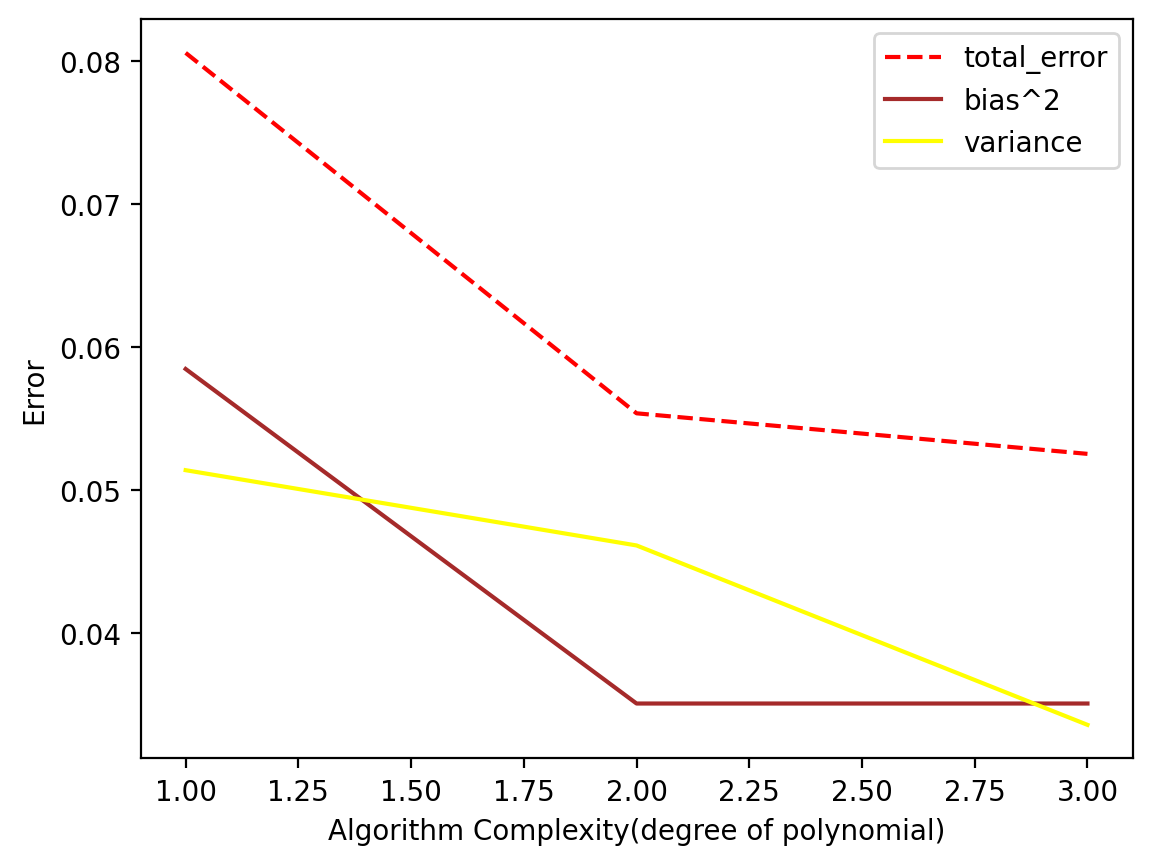

In [36]:
bias, var, error= [], [], []
max_d = 4
for d in range(1, max_d):
    clf = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=d)),
            (
                "tree",
                DecisionTreeClassifier(max_depth=2, random_state=123),
            ),
        ]
    )
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=123)
    bias.append(avg_bias)
    var.append(avg_var)
    error.append(avg_expected_loss)
plt.plot(range(1, max_d), error, 'red', label = 'total_error',linestyle='dashed')
plt.plot(range(1, max_d), bias, 'brown', label = 'bias^2')
plt.plot(range(1, max_d), var, 'yellow', label = 'variance')
plt.xlabel('Algorithm Complexity(degree of polynomial)')
plt.ylabel('Error')
plt.legend()

Выше мы видим, что общиая ожидаемая ошибка = сумма смещения + дисперсии и прунинг имеет некоторый эффект на уменьшение дисперсии. Мы также видим момент переобучения - когда bias доходит до нуля, а variance начинает повышаться.

Случайный лес, в том числе за счет бутстрапа, позволяет уменьшить ожидаемую ошибку. В его основе композиция деревьев, обученных на случайных подвыборках с помощью беггинга, при этом при каждом разбиении случайно выбирается подмножество из всех признаков. 

При беггинге (Bootstrap Aggregating) многочисленные повторы исходного набора данных создаются с использованием случайного выбора с заменой. Каждый производный набор данных затем используется для построения новой модели, и модели собираются в ансамбль. Чтобы сделать прогноз, все модели в ансамбле опрашиваются и их результаты усредняются.

В целом, беггинг (bootstrap aggregation) не увеличивает смещение модели, но при этом *всегда* уменьшает дисперсию. Интересно: В идеальном случае для MSE, обучение M нескоррелированных алгоритмов с помощью бутстрапа уменьшает ошибку в M раз! 

###  Теорема о разложении ошибки для ансамблей

Для ансамбля из $M$ моделей разложение ошибки имеет следующий вид:

$$E_{ensemble} = \bar{Bias}^2 + \frac{1}{M}Var + \left(1 - \frac{1}{M}\right)Cov$$

где:
- $\bar{Bias}^2$ - средний квадрат смещения отдельных моделей
- $Var$ - средняя дисперсия отдельных моделей
- $Cov$ - средняя ковариация между ошибками разных моделей

Таким образом: 
1. **При идеальной некоррелированности** ($Cov = 0$): ошибка ансамбля уменьшается пропорционально количеству моделей: $E_{ensemble} = \bar{Bias}^2 + \frac{1}{M}Var$
2. **При полной корреляции** ($Cov = Var$): ансамбль не дает преимущества, ошибка равна ошибке одной модели: $E_{ensemble} = \bar{Bias}^2 + Var$

3. **Bias ансамбля** равен среднему bias отдельных моделей (не уменьшается при усреднении)

4. **Variance ансамбля** уменьшается пропорционально $1/M$, но только если модели некоррелированы

Именно поэтому методы вроде Bagging и Random Forest работают так хорошо - они уменьшают корреляцию между моделями, что позволяет эффективно уменьшать variance.


В своём блоге Лео Бриман (Leo Breiman), создатель случайного леса, написал следующее:
 > Random forest does not overfit. You can run as many trees as you want.

Это относилось только к числу деревьев. В целом, мы можем ожидать, что дисперсия перестанет расти в какой-то момент. 
Проверим, так ли это. 

*Задание*: Выведите отношение ожидаемой ошибки к ошибке одной модели в случае усреднения N моделей для MSE.

In [37]:
#clf_RF = RandomForestClassifier(max_depth=4, random_state=0)
#clf_RF.fit(X_train,y_train)

pipeline = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "tree",
                RandomForestClassifier(max_depth=5, random_state=0),
            ),
        ]
    )
pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        pipeline, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))

Average expected loss: 0.036
Average bias: 0.035
Average variance: 0.011
Sklearn 0-1 loss: 0.035


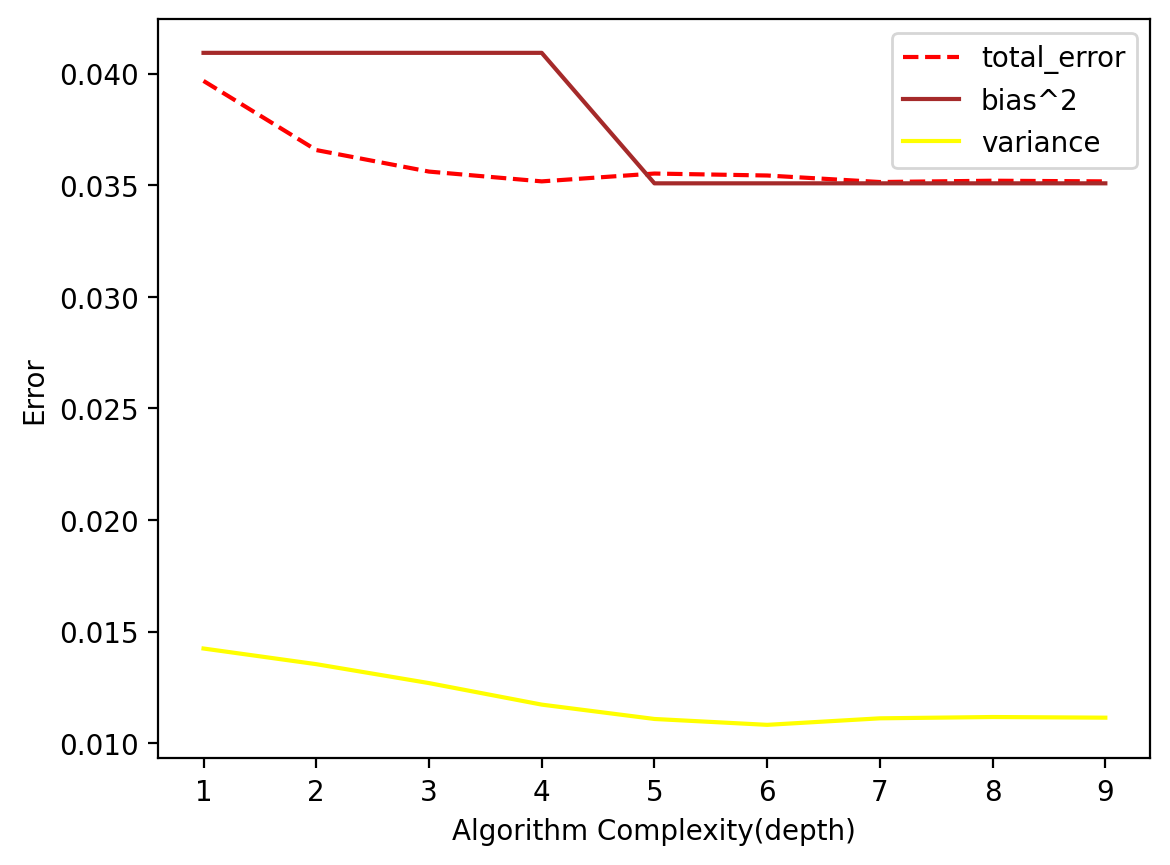

In [38]:
bias, var, error= [], [], []
max_d = 10
for d in range(1, max_d):
    clf = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=2)),
            (
                "tree",
                RandomForestClassifier(max_depth=d, random_state=123),
            ),
        ]
    )
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=123)
    bias.append(avg_bias)
    var.append(avg_var)
    error.append(avg_expected_loss)
plt.plot(range(1, max_d), error, 'red', label = 'total_error',linestyle='dashed')
plt.plot(range(1, max_d), bias, 'brown', label = 'bias^2')
plt.plot(range(1, max_d), var, 'yellow', label = 'variance')
plt.xlabel('Algorithm Complexity(depth)')
plt.ylabel('Error')
plt.legend()

In [ ]:
bias, var, error= [], [], []
ns = [50, 100, 150, 200, 250, 300]
for n in ns:
    print("====", n)
    clf = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=2)),
            (
                "tree",
                RandomForestClassifier(max_depth=10, n_estimators=n*10, random_state=123),
            ),
        ]
    )
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=123)
    bias.append(avg_bias)
    var.append(avg_var)
    error.append(avg_expected_loss)
plt.plot(ns, error, 'red', label = 'total_error',linestyle='dashed')
plt.plot(ns, bias, 'brown', label = 'bias^2')
plt.plot(ns, var, 'yellow', label = 'variance')
plt.xlabel('Algorithm Complexity(n_trees)')
plt.ylabel('Error')
plt.legend()

==== 50
==== 100
==== 150
==== 200


 На практике единственным ограничением размера леса является время вычислений, поскольку можно обучить бесконечное количество деревьев без увеличения систематической ошибки и с постоянным (хотя и асимптотически уменьшающимся) уменьшением дисперсии.


Как мы уже видели, Bagging эффективно снижает variance, не затрагивая bias. Но существуют и другие подходы к построению ансамблей, каждый из которых по-своему влияет на bias-variance разложение.

*Boosting*: В отличие от Bagging, где модели обучаются параллельно, бустинг строит модели последовательно: каждая следующая модель фокусируется на исправлении ошибок предыдущих. Это позволяет постепенно уменьшать bias, но при этом может привести к росту variance из-за усложнения модели. Поэтому бустинг особенно эффективен, когда базовые модели имеют высокий bias (например, неглубокие деревья). Типичные примеры: AdaBoost, Gradient Boosting, XGBoost.

*Stacking*: Стекинг использует мета-модель, которая учится комбинировать предсказания базовых моделей. Это позволяет объединить сильные стороны разных типов моделей (линейных, нелинейных, ансамблей), что может снизить и bias, и variance. Однако успех метода сильно зависит от разнообразия базовых моделей и аккуратной настройки.


In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import validation_curve

models_ensemble = [
    ('Single DT', DecisionTreeClassifier(max_depth=10, random_state=123)),
    ('Bagging (RF)', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=123)),
    ('Boosting (AdaBoost)', AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3, random_state=123),
        n_estimators=50, random_state=123
    )),
    ('Boosting (Gradient)', GradientBoostingClassifier(
        max_depth=3, n_estimators=50, random_state=123
    )),
]

ensemble_results = []
for name, model in models_ensemble:
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test,
        loss='0-1_loss', num_rounds=200, random_seed=123
    )
    ensemble_results.append({
        'Method': name,
        'Error': avg_expected_loss,
        'Bias': avg_bias,
        'Variance': avg_var
    })

ensemble_df = pd.DataFrame(ensemble_results)
print("Сравнение методов ансамблей:")
print(ensemble_df.to_string(index=False))


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
fig = plt.figure()

x_pos = np.arange(len(ensemble_df))
width = 0.25

plt.bar(x_pos - width, ensemble_df['Bias'], width, label='Bias', color='blue', alpha=0.7)
plt.bar(x_pos, ensemble_df['Variance'], width, label='Variance', color='orange', alpha=0.7)
plt.bar(x_pos + width, ensemble_df['Error'], width, label='Error', color='magenta', alpha=0.7)
plt.xlabel('Method', fontsize=11)
plt.ylabel('Error', fontsize=11)
plt.title('Bias, Variance, and Error for Ensemble Methods', fontsize=13)
# #region agent log
import json
import time
log_path = r"e:\projects\spbu_ml_2026\.cursor\debug.log"
try:
    with open(log_path, 'a', encoding='utf-8') as f:
        log_entry = {"id": f"log_{int(time.time() * 1000)}", "timestamp": int(time.time() * 1000), "location": "bias_variance.ipynb:cell74:hypothesis_A", "message": "Hypothesis A: Checking if plt.xticklabels exists", "data": {"hasattr_xticklabels": hasattr(plt, 'xticklabels'), "hypothesisId": "A"}, "runId": "initial_debug"}
        f.write(json.dumps(log_entry) + '\n')
except: pass
# #endregion
plt.xticks(x_pos, labels=ensemble_df['Method'], rotation=45, ha='right', fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'ensemble_df' is not defined

<Figure size 640x480 with 0 Axes>

## KNN

Давайте также попробуем заглянуть в KNN.

Обычно модель KNN с низкими значениями k имеет высокую дисперсию и низкое смещение, но по мере увеличения k дисперсия уменьшается, а смещение увеличивается.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train,y_train)
y_pred=clf_knn.predict(X_test)


avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_knn, X_train, y_train, X_test, y_test,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))

Average expected loss: 0.076
Average bias: 0.058
Average variance: 0.043
Sklearn 0-1 loss: 0.064


Можно заметить, что смещение относительно велико [для k=3] по сравнению с дисперсией. И ожидаемые  ошибки больше, чем у модели RF.

In [ ]:
ks = [i for i in range(1,21)]
model = KNeighborsClassifier()

val_curve_train, val_curve_test = validation_curve(
    estimator=model,
    X=X,
    y=y,
    param_name="n_neighbors",
    param_range=ks,
    cv=5,
    scoring="accuracy"
)

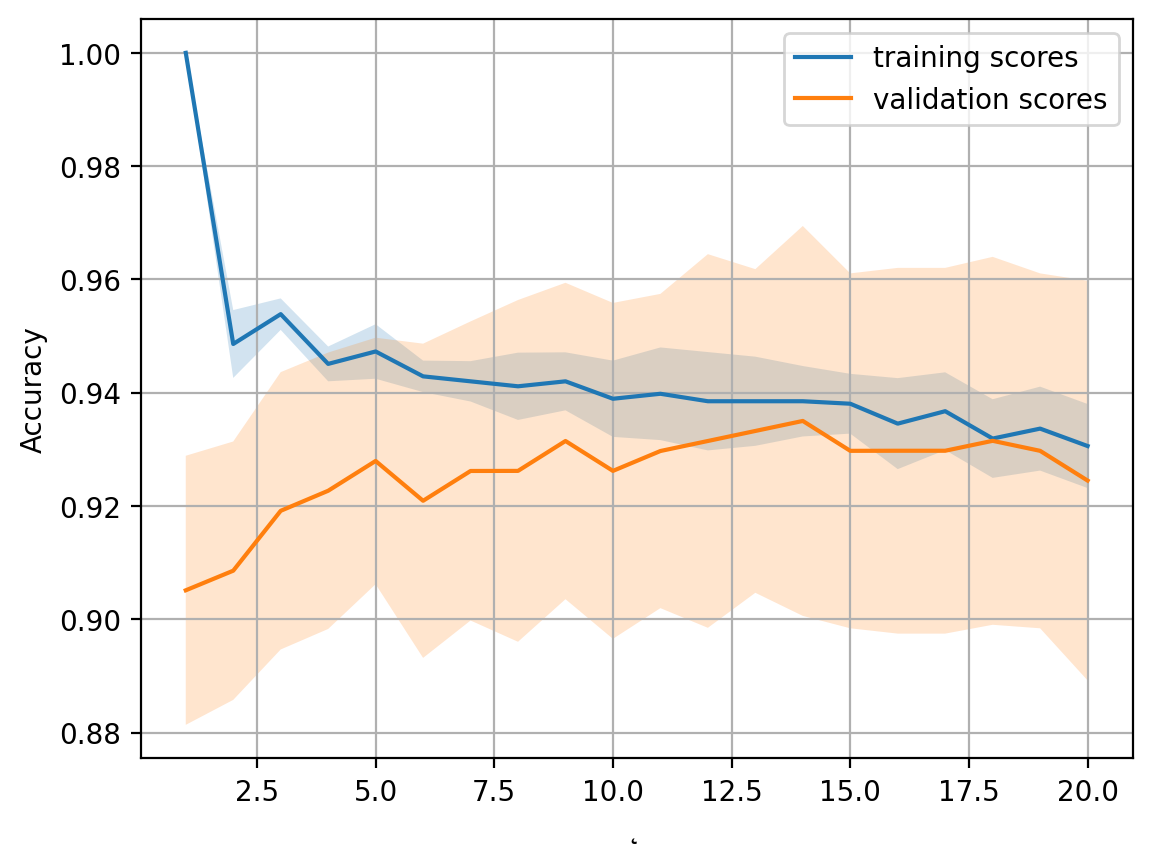

In [ ]:
plot_with_err(ks, val_curve_train, label="training scores")
plot_with_err(ks, val_curve_test, label="validation scores")
plt.xlabel(r"$\k$")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

**Задание:** Постройте validation curves для деревьев и случайного леса.

Для различных значений k в kNN давайте также рассмотрим, какими будут наши ошибки, смещение и дисперсии.

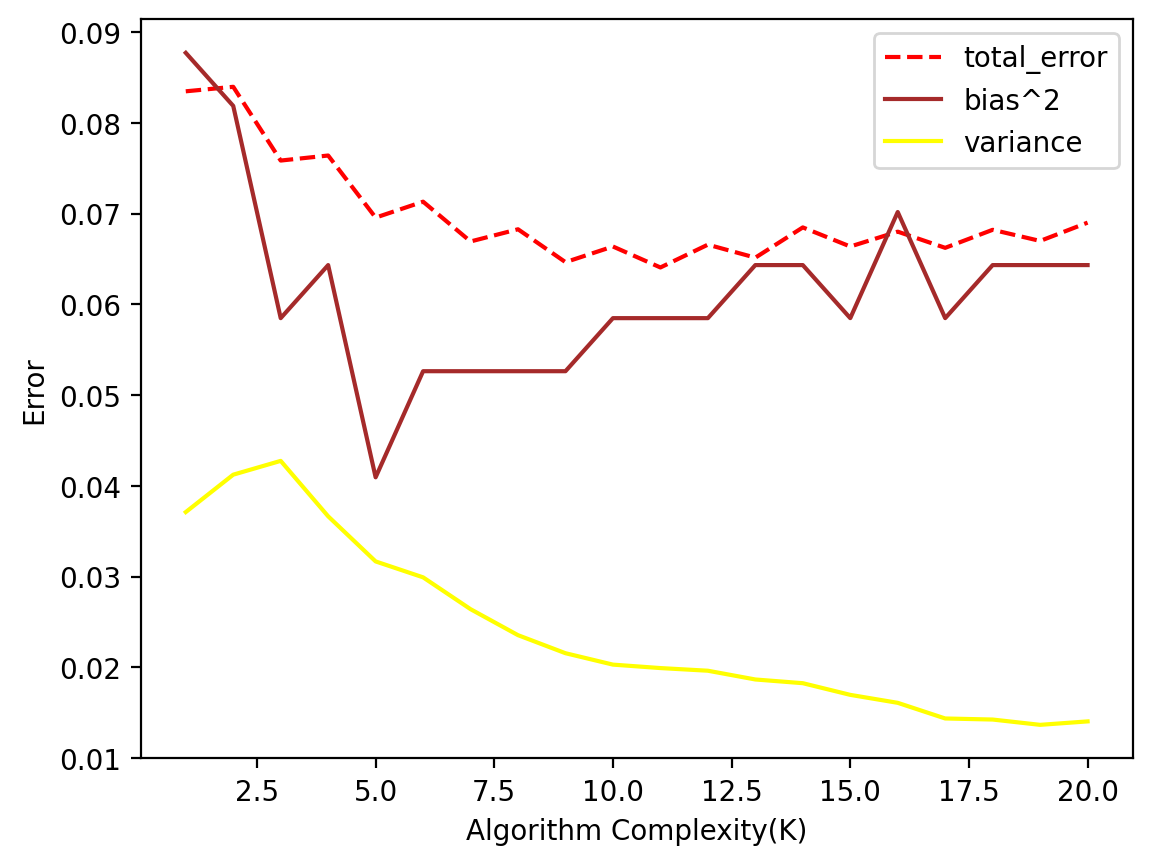

In [ ]:
bias_KnnClass, var_KnnClass,error_KnnClass, = [], [], []
for k in range(1,21):
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf_knn, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=123)
    bias_KnnClass.append(avg_bias)
    var_KnnClass.append(avg_var)
    error_KnnClass.append(avg_expected_loss)
plt.plot(range(1,21), error_KnnClass, 'red', label = 'total_error',linestyle='dashed')
plt.plot(range(1,21), bias_KnnClass, 'brown', label = 'bias^2')
plt.plot(range(1,21), var_KnnClass, 'yellow', label = 'variance')
plt.xlabel('Algorithm Complexity(K)')
plt.ylabel('Error')
plt.legend()

Как и ожидалось, при увеличении k уменьшается дисперсия (модель недообучается) и немного увеличивается смещение


**Задание**: Постройте графики зависимости bias-variance от сложности для регрессии


**Задание**: Постройте графики validation_curve от сложности для регрессии. Какая точка, по вашему мнению, соответствует наилучшему набору параметров?
